In [ ]:
#Fraud detection

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import skew, kurtosis, shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import silhouette_score

In [ ]:
#Load data
creditCardTxPath = 'ibm fraud tx/credit_card_transactions-ibm_v2.csv'
cardDataPath = 'ibm fraud tx/sd254_cards.csv'
userDataPath = 'ibm fraud tx/sd254_users.csv'
zipcodeDataPath = 'ibm fraud tx/zipcode_mapping.csv'

creditCardTxData = pd.read_csv(creditCardTxPath).reset_index()
creditCardTxData.rename(columns ={'Zip': 'MerchantZipcode'}, inplace = True)
cardData = pd.read_csv(cardDataPath)
userData = pd.read_csv(userDataPath).reset_index()
zipcodeData = pd.read_csv(zipcodeDataPath)
zipcodeData.rename(columns ={'ZIP': 'MerchantZipcode'}, inplace = True)
zipcodeData.rename(columns ={'LAT': 'MerchantLatitude'}, inplace = True)
zipcodeData.rename(columns ={'LNG': 'MerchantLongitude'}, inplace = True)
#xData = pd.read_csv(xTrainPath)
#yData = pd.read_csv(yTrainPath)
#testData = pd.read_csv(testPath, nrows=10)

In [ ]:
##########BREAK TRANSACTION INTO TRAIN AND TEST ###############
#Later break train into subtrain validation and feature engg set 
#Keep test untouched as unseen data for evaluation

#Think of likely scenario. How much of a lag to consider.

#Also decide lookback period. All past data may not be useful. 

In [ ]:
#Year 2019 is FINAL EVALUATION SET
#All data prior is used to train (including holdout)
#Year 2020 is DROPPED due to no fraud. 
creditCardTxData = creditCardTxData.drop(creditCardTxData[creditCardTxData.Year >= 2020].index)
#Extract and save 2019 tx data to be used later
tx2019 = creditCardTxData[creditCardTxData['Year'] >= 2018]
tx2019.drop('index', axis=1, inplace=True)
tx2019.to_csv('tx2019.csv', index=False)
del(tx2019)
#Remove year 2019 to prevent any possibility of leakage
creditCardTxData = creditCardTxData.drop(creditCardTxData[creditCardTxData.Year >= 2019].index)
creditCardTxData.head()

C:\Users\ayush\AppData\Local\Temp\ipykernel_19868\4070145909.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx2019.drop('index', axis=1, inplace=True)


,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?
0,0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [ ]:
#Merge zipcode data
creditCardTxData['MerchantZipcode'].fillna("MISSING_ZIP", inplace=True)
creditCardTxData['MerchantZipcode'] = creditCardTxData['MerchantZipcode'].apply(lambda value: value if isinstance(value,str) else str(int(value)))
zipcodeData['MerchantZipcode'] = zipcodeData['MerchantZipcode'].apply(lambda value: value if isinstance(value,str) else str(int(value)).zfill(5))
creditCardTxData = creditCardTxData.merge(zipcodeData, on = 'MerchantZipcode', how = 'left')
creditCardTxData.head()

,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?,MerchantLatitude,MerchantLongitude
0,0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750,5300,NaN,No,34.180010,-117.773939
1,1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,NaN,No,34.052922,-118.143465
2,2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,NaN,No,34.052922,-118.143465
3,3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754,5651,NaN,No,34.052922,-118.143465
4,4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750,5912,NaN,No,34.180010,-117.773939


In [ ]:
len(creditCardTxData)

22326462

In [ ]:
cardData.head()

,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [ ]:
cardData.columns

Index(['User', 'CARD INDEX', 'Card Brand', 'Card Type', 'Card Number',
       'Expires', 'CVV', 'Has Chip', 'Cards Issued', 'Credit Limit',
       'Acct Open Date', 'Year PIN last Changed', 'Card on Dark Web'],
      dtype='object')

In [ ]:
#dummy card data for join
# cardData = cardData[['User', 'CARD INDEX', 'Card Brand', 'Card Type', 'Has Chip', 'Cards Issued', 'Credit Limit',
#        'Acct Open Date', 'Year PIN last Changed']]
cardData.drop('Card on Dark Web', axis=1, inplace=True)

cardData['Expires'] = pd.to_datetime(cardData['Expires'], format = '%m/%Y').dt.strftime('%Y-%m')

cardData['Acct Open Date'] = pd.to_datetime(cardData['Acct Open Date'], format = '%m/%Y').dt.strftime('%Y-%m')
cardData['Acct Open Date'] = cardData['Acct Open Date'].apply(lambda value: int(value.split("-")[0]))

cardData['Credit Limit'] = cardData['Credit Limit'].apply(lambda value: float(value.split("$")[1]))
cardData.rename(columns ={'User': 'UserIndex'}, inplace = True)
cardData['UserCardKey'] = cardData['UserIndex'].astype(str) + "_" + cardData['CARD INDEX'].astype(str)

In [ ]:
#Get acct age and year pin last changed age after analysis <- ask bansi
cardData.head()

,UserIndex,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,UserCardKey
0,0,0,Visa,Debit,4344676511950444,2022-12,623,YES,2,24295.0,2002,2008,0_0
1,0,1,Visa,Debit,4956965974959986,2020-12,393,YES,2,21968.0,2014,2014,0_1
2,0,2,Visa,Debit,4582313478255491,2024-02,719,YES,2,46414.0,2003,2004,0_2
3,0,3,Visa,Credit,4879494103069057,2024-08,693,NO,1,12400.0,2003,2012,0_3
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,2009-03,75,YES,1,28.0,2008,2009,0_4


In [ ]:
cardData = cardData[['UserIndex', 'CARD INDEX', 'Card Brand', 'Card Type', 'Has Chip', 'Cards Issued', 'Credit Limit', 'Acct Open Date', 'Year PIN last Changed', 'UserCardKey']]
cardData.head()

,UserIndex,CARD INDEX,Card Brand,Card Type,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,UserCardKey
0,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_0
1,0,1,Visa,Debit,YES,2,21968.0,2014,2014,0_1
2,0,2,Visa,Debit,YES,2,46414.0,2003,2004,0_2
3,0,3,Visa,Credit,NO,1,12400.0,2003,2012,0_3
4,0,4,Mastercard,Debit (Prepaid),YES,1,28.0,2008,2009,0_4


In [ ]:
len(cardData)

6146

In [ ]:
userData.head()

,index,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [ ]:
userData.columns

Index(['index', 'Person', 'Current Age', 'Retirement Age', 'Birth Year',
       'Birth Month', 'Gender', 'Address', 'Apartment', 'City', 'State',
       'Zipcode', 'Latitude', 'Longitude', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards'],
      dtype='object')

In [ ]:
age_bins = [0, 18, 30, 40, 50, 60, 120] # specify the age bins as needed
userData['Current Age Bin'] = pd.cut(userData['Current Age'], bins=age_bins, labels=['0-18', '18-30', 
                                                                                     '30-40', '40-50', 
                                                                                     '50-60', '60+'], right=False)
userData = userData[['index', 'Current Age', 'Current Age Bin', 'Gender', 'Zipcode', 'Latitude', 'Longitude', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt', 'FICO Score','Num Credit Cards']]

In [ ]:
###dummy user data for join
# userData = userData[['index', 'Current Age', 'Retirement Age', 'Gender', 'City', 'State', 'Zipcode', 'Per Capita Income - Zipcode',
#        'Yearly Income - Person', 'Total Debt', 'FICO Score', 'Num Credit Cards']]

userData['Zipcode'] = userData['Zipcode'].apply(lambda value: value if isinstance(value,str) else str(int(value)))
userData['Per Capita Income - Zipcode'] = userData['Per Capita Income - Zipcode'].apply(lambda value: float(value.split("$")[1]))
userData['Yearly Income - Person'] = userData['Yearly Income - Person'].apply(lambda value: float(value.split("$")[1]))
userData['Total Debt'] = userData['Total Debt'].apply(lambda value: float(value.split("$")[1]))
userData.rename(columns ={'index': 'User'}, inplace = True)
userData.head()

,User,Current Age,Current Age Bin,Gender,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1,53,50-60,Female,11363,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,2,81,60+,Female,91792,34.02,-117.89,22681.0,33483.0,196.0,698,5
3,3,63,60+,Female,10069,40.71,-73.99,163145.0,249925.0,202328.0,722,4
4,4,43,40-50,Male,94117,37.76,-122.44,53797.0,109687.0,183855.0,675,1


In [ ]:
#User data clustering

In [ ]:
df_users_features_segment = userData[['Current Age','Yearly Income - Person','FICO Score','Total Debt','Num Credit Cards']]
df_users_features_segment['Yearly Income - Person'] = df_users_features_segment['Yearly Income - Person'].replace('[^0-9]+', '', regex=True).astype(int)
df_users_features_segment['Total Debt'] = df_users_features_segment['Total Debt'].replace('[^0-9]+', '', regex=True).astype(int)
df_users_features_segment.head()

C:\Users\ayush\AppData\Local\Temp\ipykernel_19868\1611580206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_features_segment['Yearly Income - Person'] = df_users_features_segment['Yearly Income - Person'].replace('[^0-9]+', '', regex=True).astype(int)
C:\Users\ayush\AppData\Local\Temp\ipykernel_19868\1611580206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_features_segment['Total Debt'] = df_users_features_segment['Total Debt'].replace('[^0-9]+', '', regex=True).astype(int)


,Current Age,Yearly Income - Person,FICO Score,Total Debt,Num Credit Cards
0,53,59696,787,127613,5
1,53,77254,701,191349,5
2,81,33483,698,196,5
3,63,249925,722,202328,4
4,43,109687,675,183855,1


In [ ]:
df_users_features_segment.shape

(2000, 5)

In [ ]:
#PCA BEFORE CLUSTERING
pca = PCA(5)
df = pca.fit_transform(df_users_features_segment)
df.shape

(2000, 5)

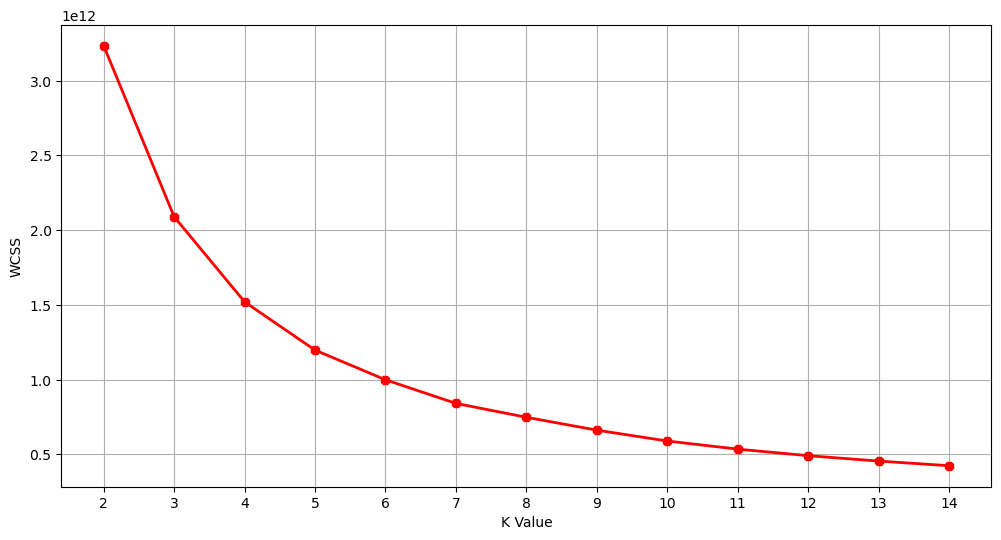

In [ ]:
wcss = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(2,15),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(2,15,1))
plt.ylabel("WCSS")
plt.show()

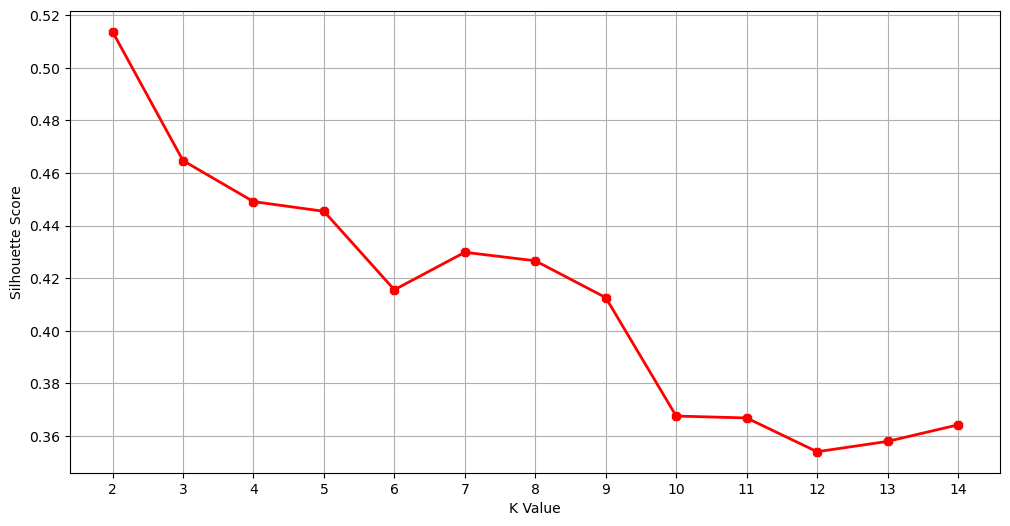

In [ ]:
sScore = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit_predict(df)
    score = silhouette_score(df, kmeans.labels_, metric = 'euclidean')
    sScore.append(score)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(2,15),sScore, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(2,15,1))
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
km = KMeans(n_clusters=7, init='k-means++')
clusters = km.fit_predict(df)
df_users_features_segment["label"] = clusters
silhouette_score(df, km.labels_, metric = 'euclidean')

C:\Users\ayush\AppData\Local\Temp\ipykernel_19868\4147208326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_features_segment["label"] = clusters


0.42983953142957965

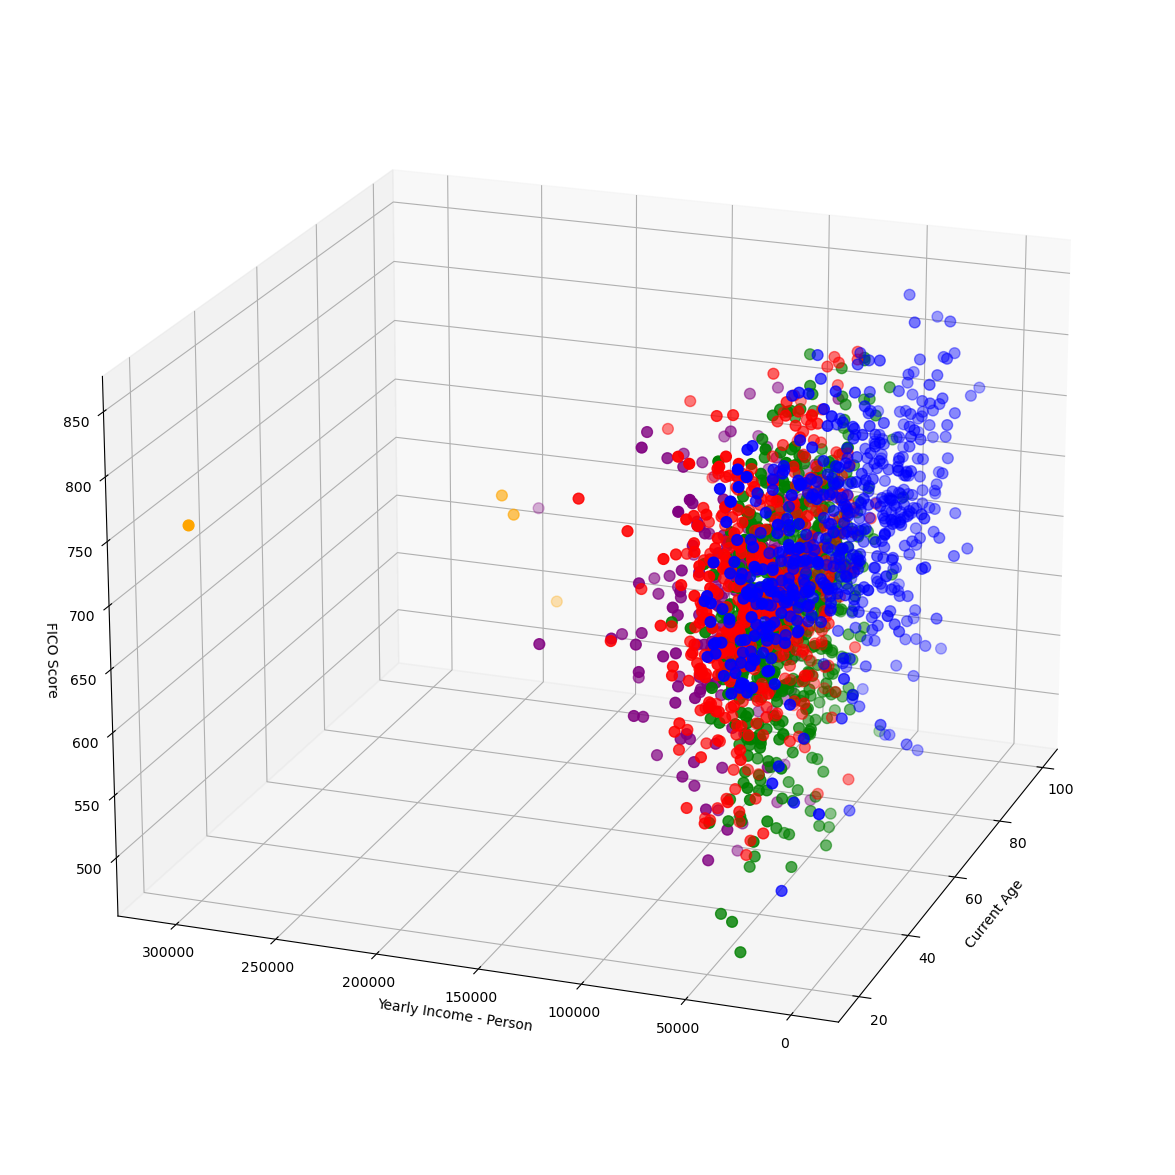

In [ ]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_users_features_segment['Current Age'][df_users_features_segment.label == 0], df_users_features_segment['Yearly Income - Person'][df_users_features_segment.label == 0], df_users_features_segment['FICO Score'][df_users_features_segment.label == 0], c='blue', s=60)
ax.scatter(df_users_features_segment['Current Age'][df_users_features_segment.label == 1], df_users_features_segment['Yearly Income - Person'][df_users_features_segment.label == 1], df_users_features_segment['FICO Score'][df_users_features_segment.label == 1], c='red', s=60)
ax.scatter(df_users_features_segment['Current Age'][df_users_features_segment.label == 2], df_users_features_segment['Yearly Income - Person'][df_users_features_segment.label == 2], df_users_features_segment['FICO Score'][df_users_features_segment.label == 2], c='green', s=60)
ax.scatter(df_users_features_segment['Current Age'][df_users_features_segment.label == 3], df_users_features_segment['Yearly Income - Person'][df_users_features_segment.label == 3], df_users_features_segment['FICO Score'][df_users_features_segment.label == 3], c='orange', s=60)
ax.scatter(df_users_features_segment['Current Age'][df_users_features_segment.label == 4], df_users_features_segment['Yearly Income - Person'][df_users_features_segment.label == 4], df_users_features_segment['FICO Score'][df_users_features_segment.label == 4], c='purple', s=60)
ax.view_init(20, 200)
plt.xlabel("Current Age")
plt.ylabel("Yearly Income - Person")
ax.set_zlabel('FICO Score')
plt.show()

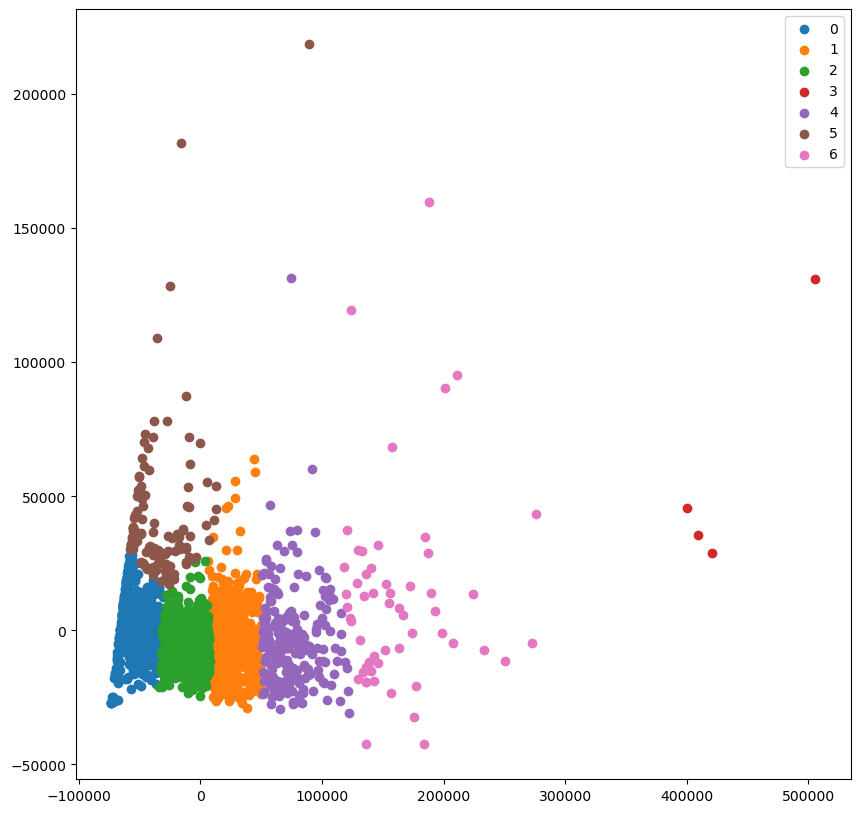

In [ ]:
u_labels = np.unique(clusters)
fig = plt.figure(figsize = (10,10))

for i in u_labels:
    plt.scatter(df[clusters == i , 0] , df[clusters == i , 1] , label = i)
plt.legend()
plt.show()

In [ ]:
df_users_features_segment.reset_index(inplace=True)
df_users_features_segment.rename(columns ={'index': 'User'}, inplace = True)
df_users_features_segment

C:\Users\ayush\AppData\Local\Temp\ipykernel_19868\4214477527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_features_segment.rename(columns ={'index': 'User'}, inplace = True)


,User,Current Age,Yearly Income - Person,FICO Score,Total Debt,Num Credit Cards,label
0,0,53,59696,787,127613,5,4
1,1,53,77254,701,191349,5,6
2,2,81,33483,698,196,5,0
3,3,63,249925,722,202328,4,6
4,4,43,109687,675,183855,1,6
...,...,...,...,...,...,...,...
1995,1995,32,48010,703,87837,3,1
1996,1996,62,49378,740,104480,4,1
1997,1997,47,30942,779,71066,3,2
1998,1998,66,54654,618,27241,1,5


In [ ]:
userData

,User,Current Age,Current Age Bin,Gender,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1,53,50-60,Female,11363,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,2,81,60+,Female,91792,34.02,-117.89,22681.0,33483.0,196.0,698,5
3,3,63,60+,Female,10069,40.71,-73.99,163145.0,249925.0,202328.0,722,4
4,4,43,40-50,Male,94117,37.76,-122.44,53797.0,109687.0,183855.0,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,32,30-40,Male,11520,40.65,-73.58,23550.0,48010.0,87837.0,703,3
1996,1996,62,60+,Female,41051,38.95,-84.54,24218.0,49378.0,104480.0,740,4
1997,1997,47,40-50,Female,7201,40.66,-74.19,15175.0,30942.0,71066.0,779,3
1998,1998,66,60+,Male,17011,40.24,-76.92,25336.0,54654.0,27241.0,618,1


In [ ]:
df_users_features_segment['label'].value_counts()

label
2    616
0    529
1    472
4    209
5    114
6     56
3      4
Name: count, dtype: int64

In [ ]:
df_users_features_segment[['User', 'label']]

,User,label
0,0,4
1,1,6
2,2,0
3,3,6
4,4,6
...,...,...
1995,1995,1
1996,1996,1
1997,1997,2
1998,1998,5


In [ ]:
userData = userData.merge(df_users_features_segment[['User', 'label']], on = 'User', how = 'left')
userData.rename(columns ={'label': 'UserCluster'}, inplace = True)
userData

,User,Current Age,Current Age Bin,Gender,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,UserCluster
0,0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4
1,1,53,50-60,Female,11363,40.76,-73.74,37891.0,77254.0,191349.0,701,5,6
2,2,81,60+,Female,91792,34.02,-117.89,22681.0,33483.0,196.0,698,5,0
3,3,63,60+,Female,10069,40.71,-73.99,163145.0,249925.0,202328.0,722,4,6
4,4,43,40-50,Male,94117,37.76,-122.44,53797.0,109687.0,183855.0,675,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,32,30-40,Male,11520,40.65,-73.58,23550.0,48010.0,87837.0,703,3,1
1996,1996,62,60+,Female,41051,38.95,-84.54,24218.0,49378.0,104480.0,740,4,1
1997,1997,47,40-50,Female,7201,40.66,-74.19,15175.0,30942.0,71066.0,779,3,2
1998,1998,66,60+,Male,17011,40.24,-76.92,25336.0,54654.0,27241.0,618,1,5


In [ ]:
len(userData)

2000

In [ ]:
#Null treatement
creditCardTxData.isna().sum()

index                       0
User                        0
Card                        0
Year                        0
Month                       0
Day                         0
Time                        0
Amount                      0
Use Chip                    0
Merchant Name               0
Merchant City               0
Merchant State        2462394
MerchantZipcode             0
MCC                         0
Errors?              21970622
Is Fraud?                   0
MerchantLatitude      4292124
MerchantLongitude     4292124
dtype: int64

In [ ]:
creditCardTxData['Merchant State'].fillna("MISSING_STATE", inplace=True)
#creditCardTxData['Zip'].fillna("MISSING_ZIP", inplace=True)
creditCardTxData['MerchantLatitude'].fillna(0, inplace=True)
creditCardTxData['MerchantLongitude'].fillna(0, inplace=True)

creditCardTxData['Errors?'].fillna("No", inplace=True)
creditCardTxData['Is Fraud?'].fillna('No', inplace=True)

In [ ]:
creditCardTxData.isna().sum()

index                0
User                 0
Card                 0
Year                 0
Month                0
Day                  0
Time                 0
Amount               0
Use Chip             0
Merchant Name        0
Merchant City        0
Merchant State       0
MerchantZipcode      0
MCC                  0
Errors?              0
Is Fraud?            0
MerchantLatitude     0
MerchantLongitude    0
dtype: int64

In [ ]:
cardData.isna().sum()

UserIndex                0
CARD INDEX               0
Card Brand               0
Card Type                0
Has Chip                 0
Cards Issued             0
Credit Limit             0
Acct Open Date           0
Year PIN last Changed    0
UserCardKey              0
dtype: int64

In [ ]:
userData.isna().sum()

User                           0
Current Age                    0
Current Age Bin                0
Gender                         0
Zipcode                        0
Latitude                       0
Longitude                      0
Per Capita Income - Zipcode    0
Yearly Income - Person         0
Total Debt                     0
FICO Score                     0
Num Credit Cards               0
UserCluster                    0
dtype: int64

In [ ]:
userData[userData['User'] == 300]

,User,Current Age,Current Age Bin,Gender,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,UserCluster
300,300,101,60+,Female,86337,35.13,-112.99,13086.0,15348.0,1396.0,761,4,0


In [ ]:
#Pre process transaction
creditCardTxData.head()
#base.drop('Is Fraud?', inplace = True, axis=1)


,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?,MerchantLatitude,MerchantLongitude
0,0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750,5300,No,No,34.180010,-117.773939
1,1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,No,No,34.052922,-118.143465
2,2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,No,No,34.052922,-118.143465
3,3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754,5651,No,No,34.052922,-118.143465
4,4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750,5912,No,No,34.180010,-117.773939


In [ ]:
creditCardTxData.loc[creditCardTxData['Is Fraud?'] == 'No', 'TARGET'] = 0
creditCardTxData.loc[creditCardTxData['Is Fraud?'] == 'Yes', 'TARGET'] = 1
creditCardTxData['Amount'] = creditCardTxData['Amount'].apply(lambda value: float(value.split("$")[1]))
creditCardTxData['UserCardKey'] = creditCardTxData['User'].astype(str) + "_" + creditCardTxData['Card'].astype(str)


In [ ]:
creditCardTxData.head()


,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?,MerchantLatitude,MerchantLongitude,TARGET,UserCardKey
0,0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750,5300,No,No,34.180010,-117.773939,0.0,0_0
1,1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,No,No,34.052922,-118.143465,0.0,0_0
2,2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754,5411,No,No,34.052922,-118.143465,0.0,0_0
3,3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754,5651,No,No,34.052922,-118.143465,0.0,0_0
4,4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750,5912,No,No,34.180010,-117.773939,0.0,0_0


In [ ]:
#Engineered and insight features:

#Hour
creditCardTxData['Hour'] = creditCardTxData['Time'].apply(lambda value: int(value.split(":")[0]))

#Minute
creditCardTxData['Minute'] = creditCardTxData['Time'].apply(lambda value: int(value.split(":")[1]))

#In market time. hour between 7 and 16 inclusive
creditCardTxData.loc[(creditCardTxData['Hour'] > 6) & (creditCardTxData['Hour'] < 17), 'InMarketTime'] = 1
creditCardTxData.loc[(creditCardTxData['Hour'] < 7) | (creditCardTxData['Hour'] > 16), 'InMarketTime'] = 0

#Is Online
creditCardTxData.loc[creditCardTxData['Hour'] == 'Online Transaction', 'IsOnline'] = 1
creditCardTxData.loc[creditCardTxData['Hour'] != 'Online Transaction', 'IsOnline'] = 0

#Top 10 most fraud merchant
t10FraudMerchant = creditCardTxData[creditCardTxData['Is Fraud?'] == 'Yes'].groupby(['Merchant Name','Is Fraud?'])[['index']].count().reset_index().nlargest(10, 'index')['Merchant Name'].tolist()
creditCardTxData.loc[creditCardTxData['Merchant Name'].isin(t10FraudMerchant), 'fraudMerchant'] = 1
creditCardTxData['fraudMerchant'].fillna(0, inplace=True)

#Top 10 most fraud state
t10FraudState = creditCardTxData[creditCardTxData['Is Fraud?'] == 'Yes'].groupby(['Merchant State','Is Fraud?'])[['index']].count().reset_index().nlargest(10, 'index')['Merchant State'].tolist()
creditCardTxData.loc[creditCardTxData['Merchant State'].isin(t10FraudState), 'fraudMerchantState'] = 1
creditCardTxData['fraudMerchantState'].fillna(0, inplace=True)

#Top 10 most fraud city
t10FraudCity = creditCardTxData[creditCardTxData['Is Fraud?'] == 'Yes'].groupby(['Merchant City','Is Fraud?'])[['index']].count().reset_index().nlargest(10, 'index')['Merchant City'].tolist()
creditCardTxData.loc[creditCardTxData['Merchant City'].isin(t10FraudCity), 'fraudMerchantCity'] = 1
creditCardTxData['fraudMerchantCity'].fillna(0, inplace=True)

#Top 10 most fraud zip
t10FraudZip = creditCardTxData[creditCardTxData['Is Fraud?'] == 'Yes'].groupby(['MerchantZipcode','Is Fraud?'])[['index']].count().reset_index().nlargest(10, 'index')['MerchantZipcode'].tolist()
creditCardTxData.loc[creditCardTxData['MerchantZipcode'].isin(t10FraudZip), 'fraudMerchantZip'] = 1
creditCardTxData['fraudMerchantZip'].fillna(0, inplace=True)

#Top 6 error (CVV, Num, PIN, Expiry, Balance, tech glitch)
t6Errors = ['Technical Glitch', 'Insufficient Balance', 'Bad PIN', 'Bad Expiration', 'Bad Card Number', 'Bad CVV']
creditCardTxData.loc[creditCardTxData['Errors?'].isin(t6Errors), 'topError'] = 1
creditCardTxData['topError'].fillna(0, inplace=True)

# #Lag top 5 error lag 1, 2, 3 CREATE IN PLACE WHEN RUNNING MODEL PER userCard key to prevent spillage
# creditCardTxData['topError_lag1'] = creditCardTxData['topError'].shift(1)
# creditCardTxData.loc[0, 'topError_lag1'] = creditCardTxData.topError_lag1[creditCardTxData.topError_lag1.notnull()].values[0]

# creditCardTxData['topError_lag2'] = creditCardTxData['topError'].shift(2)
# creditCardTxData.loc[0, 'topError_lag2'] = creditCardTxData.topError_lag2[creditCardTxData.topError_lag2.notnull()].values[0]

# creditCardTxData['topError_lag3'] = creditCardTxData['topError'].shift(3)
# creditCardTxData.loc[0, 'topError_lag3'] = creditCardTxData.topError_lag3[creditCardTxData.topError_lag3.notnull()].values[0]


In [ ]:
creditCardTxData.head()


,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,...,UserCardKey,Hour,Minute,InMarketTime,IsOnline,fraudMerchant,fraudMerchantState,fraudMerchantCity,fraudMerchantZip,topError
0,0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,...,0_0,6,21,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,...,0_0,6,42,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,...,0_0,6,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,...,0_0,17,45,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,...,0_0,6,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
creditCardTxData.isna().sum()

index                 0
User                  0
Card                  0
Year                  0
Month                 0
Day                   0
Time                  0
Amount                0
Use Chip              0
Merchant Name         0
Merchant City         0
Merchant State        0
MerchantZipcode       0
MCC                   0
Errors?               0
Is Fraud?             0
MerchantLatitude      0
MerchantLongitude     0
TARGET                0
UserCardKey           0
Hour                  0
Minute                0
InMarketTime          0
IsOnline              0
fraudMerchant         0
fraudMerchantState    0
fraudMerchantCity     0
fraudMerchantZip      0
topError              0
dtype: int64

In [ ]:
#Join tx -> users on tx.User and user.User
creditCardTxData = creditCardTxData.merge(userData, on = 'User', how = 'left')


In [ ]:
#Recover memory
#del(userData)

In [ ]:
#Use haversine formula to get distance between MerchantZip and User zip

# Define a custom function to calculate the distance between two points using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Convert coordinates to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    r = 6371  # Radius of the earth in km
    distance = r * c
    return abs(distance)

# Calculate the distance between the two sets of coordinates using the haversine function
creditCardTxData['MerchantUserDistance'] = creditCardTxData.apply(lambda row: haversine(row['Latitude'], row['Longitude'], row['MerchantLatitude'], row['MerchantLongitude']), axis=1)

creditCardTxData.head()

,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,...,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,UserCluster,MerchantUserDistance
0,0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,...,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,3.574914
1,1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,...,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,36.920592
2,2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,...,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,36.920592
3,3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,...,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,36.920592
4,4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,...,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,3.574914


In [ ]:
#Join tx -> cards on tx.UserCardKey, tx.Card and card.UserCardKey
creditCardTxData = creditCardTxData.merge(cardData, on = 'UserCardKey', how = 'left')

In [ ]:
#Recover memory
#del(cardData)
creditCardTxData['UserClusterKey'] = creditCardTxData['User'].astype(str) + "_" + creditCardTxData['UserCluster'].astype(str)

In [ ]:
#Currently NO NEW USERS are added to the system. If a new user would have been added, 
#the learned k means would need to be applied first to assign a cluster to 
#the new user and then this would be used. NOT DONE FOR THIS PROJECT but would be done in an actual implementation

In [ ]:
#Other features:

#Transaction
creditCardTxData['date'] = pd.to_datetime(creditCardTxData[['Year', 'Month', 'Day']])
creditCardTxData['dateHour'] = pd.to_datetime(creditCardTxData[['Year', 'Month', 'Day', 'Hour']])

#AMOUNT
#Daily Spend:
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='date', freq='D')])['Amount'].sum()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'DailySpend'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')

#Weekly Average Spend
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['Amount'].mean()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'WeeklyAverageSpend'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
creditCardTxData.fillna(method='ffill', inplace=True)

#Daily:Weekly spend ratio
#creditCardTxData['DailyWeeklySpendRatio'] = creditCardTxData['DailySpend'] / creditCardTxData['WeeklyAverageSpend']
creditCardTxData['DailyWeeklySpendRatio'] = np.where(creditCardTxData['WeeklyAverageSpend'] == 0, 1, creditCardTxData['DailySpend'] / creditCardTxData['WeeklyAverageSpend'])

#Hourly Spend:
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='dateHour', freq='H')])['Amount'].sum()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'HourlySpend'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'dateHour'], how='left')

#Average hourly spend over a week:
#Weekly Average Spend
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['HourlySpend'].mean()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'HourlySpend': 'WeeklyAverageHourlySpend'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
creditCardTxData.fillna(method='ffill', inplace=True)

#Hourly:Hourly Average per Week spend ratio
#creditCardTxData['HourlyWeeklySpendRatio'] = creditCardTxData['HourlySpend'] / creditCardTxData['WeeklyAverageHourlySpend']
creditCardTxData['HourlyWeeklySpendRatio'] = np.where(creditCardTxData['WeeklyAverageHourlySpend'] == 0, 1, creditCardTxData['HourlySpend'] / creditCardTxData['WeeklyAverageHourlySpend'])

#Same as above but on frequency instead of dollar amounts:

#Daily frequency:
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='date', freq='D')])['Amount'].count()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'DailyFrequencySpend'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')

#Weekly frequency
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['Amount'].count()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'WeeklyFrequencySpend'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
creditCardTxData.fillna(method='ffill', inplace=True)

#Daily:Weekly count ratio
#creditCardTxData['DailyWeeklyCountTxRatio'] = creditCardTxData['DailyFrequencySpend'] / creditCardTxData['WeeklyFrequencySpend']
creditCardTxData['DailyWeeklyCountTxRatio'] = np.where(creditCardTxData['WeeklyFrequencySpend'] == 0, 1, creditCardTxData['DailyFrequencySpend'] / creditCardTxData['WeeklyFrequencySpend'])

#Hourly frequency:
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='dateHour', freq='H')])['Amount'].count()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'HourlyFrequency'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'dateHour'], how='left')

#Average hourly frequency over a week:
#Weekly Average frequency
avgAmountByUserCard = creditCardTxData.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['HourlyFrequency'].mean()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'HourlyFrequency': 'WeeklyAverageHourlyFrequency'}, inplace=True)
creditCardTxData = pd.merge(creditCardTxData, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
creditCardTxData.fillna(method='ffill', inplace=True)

#Hourly:Hourly Average per Week frequency ratio
#creditCardTxData['HourlyWeeklyFrequencyRatio'] = creditCardTxData['HourlyFrequency'] / creditCardTxData['WeeklyAverageHourlyFrequency']
creditCardTxData['HourlyWeeklyFrequencyRatio'] = np.where(creditCardTxData['WeeklyAverageHourlyFrequency'] == 0, 1, creditCardTxData['HourlyFrequency'] / creditCardTxData['WeeklyAverageHourlyFrequency'])

#Cards
creditCardTxData['PIN_Change_Age'] = abs(creditCardTxData['Year PIN last Changed'] - creditCardTxData['Year'])
creditCardTxData['Account_Age'] = abs(creditCardTxData['Acct Open Date'] - creditCardTxData['Year'])

#Users
#Add volume features:
#->The ratio of total amount a credit cardholder has spent in the last 24 hours : Historical daily average spend


In [ ]:
creditCardTxData.head()

,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,...,WeeklyAverageHourlySpend,HourlyWeeklySpendRatio,DailyFrequencySpend,WeeklyFrequencySpend,DailyWeeklyCountTxRatio,HourlyFrequency,WeeklyAverageHourlyFrequency,HourlyWeeklyFrequencyRatio,PIN_Change_Age,Account_Age
0,0,0,0,2002,9,1,06:21,134.09,Swipe Transaction,3527213246127876953,...,172.57,1.000000,2,2.0,1.0,2,2.0,1.0,6,0
1,1,0,0,2002,9,1,06:42,38.48,Swipe Transaction,-727612092139916043,...,172.57,1.000000,2,2.0,1.0,2,2.0,1.0,6,0
2,2,0,0,2002,9,2,06:22,120.34,Swipe Transaction,-727612092139916043,...,172.57,0.697340,2,2.0,1.0,1,2.0,0.5,6,0
3,3,0,0,2002,9,2,17:45,128.95,Swipe Transaction,3414527459579106770,...,172.57,0.747233,2,2.0,1.0,1,2.0,0.5,6,0
4,4,0,0,2002,9,3,06:23,104.71,Swipe Transaction,5817218446178736267,...,172.57,0.606768,2,2.0,1.0,1,2.0,0.5,6,0


In [ ]:
creditCardTxData.columns

Index(['index', 'User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount',
       'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State',
       'MerchantZipcode', 'MCC', 'Errors?', 'Is Fraud?', 'MerchantLatitude',
       'MerchantLongitude', 'TARGET', 'UserCardKey', 'Hour', 'Minute',
       'InMarketTime', 'IsOnline', 'fraudMerchant', 'fraudMerchantState',
       'fraudMerchantCity', 'fraudMerchantZip', 'topError', 'Current Age',
       'Current Age Bin', 'Gender', 'Zipcode', 'Latitude', 'Longitude',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards', 'UserCluster', 'MerchantUserDistance',
       'UserIndex', 'CARD INDEX', 'Card Brand', 'Card Type', 'Has Chip',
       'Cards Issued', 'Credit Limit', 'Acct Open Date',
       'Year PIN last Changed', 'UserClusterKey', 'date', 'dateHour',
       'DailySpend', 'WeeklyAverageSpend', 'DailyWeeklySpendRatio',
       'HourlySpend', 'WeeklyAverageHourlySpend', 'HourlyWee

In [ ]:
creditCardTxData = creditCardTxData[['index', 'UserClusterKey', 'UserCardKey', 'UserCluster', 'Year', 'Month', 'Day', 'Hour', 'Amount',
       'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 
       'MCC', 'Errors?', 'InMarketTime', 'IsOnline', 'fraudMerchant',
       'fraudMerchantState', 'fraudMerchantCity', 'fraudMerchantZip',
       'topError', 'Current Age', 'Current Age Bin', 'Gender', 'MerchantUserDistance',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards', 'Card Brand', 'Card Type', 'Has Chip', 'Cards Issued',
       'Credit Limit', 'DailySpend', 'WeeklyAverageSpend', 'DailyWeeklySpendRatio', 'HourlySpend',
       'WeeklyAverageHourlySpend', 'HourlyWeeklySpendRatio', 'DailyFrequencySpend', 'WeeklyFrequencySpend',
       'DailyWeeklyCountTxRatio', 'HourlyFrequency', 'WeeklyAverageHourlyFrequency', 'HourlyWeeklyFrequencyRatio',
       'PIN_Change_Age', 'Account_Age', 'TARGET'
]]


In [ ]:
pd.set_option('display.max_columns', None)
creditCardTxData.head()

,index,UserClusterKey,UserCardKey,UserCluster,Year,Month,Day,Hour,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MCC,Errors?,InMarketTime,IsOnline,fraudMerchant,fraudMerchantState,fraudMerchantCity,fraudMerchantZip,topError,Current Age,Current Age Bin,Gender,MerchantUserDistance,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Card Brand,Card Type,Has Chip,Cards Issued,Credit Limit,DailySpend,WeeklyAverageSpend,DailyWeeklySpendRatio,HourlySpend,WeeklyAverageHourlySpend,HourlyWeeklySpendRatio,DailyFrequencySpend,WeeklyFrequencySpend,DailyWeeklyCountTxRatio,HourlyFrequency,WeeklyAverageHourlyFrequency,HourlyWeeklyFrequencyRatio,PIN_Change_Age,Account_Age,TARGET
0,0,0_4,0_0,4,2002,9,1,6,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,5300,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,3.574914,29278.0,59696.0,127613.0,787,5,Visa,Debit,YES,2,24295.0,172.57,86.285,2.000000,172.57,172.57,1.000000,2,2.0,1.0,2,2.0,1.0,6,0,0.0
1,1,0_4,0_0,4,2002,9,1,6,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,5411,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,36.920592,29278.0,59696.0,127613.0,787,5,Visa,Debit,YES,2,24295.0,172.57,86.285,2.000000,172.57,172.57,1.000000,2,2.0,1.0,2,2.0,1.0,6,0,0.0
2,2,0_4,0_0,4,2002,9,2,6,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,5411,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,36.920592,29278.0,59696.0,127613.0,787,5,Visa,Debit,YES,2,24295.0,249.29,86.285,2.889146,120.34,172.57,0.697340,2,2.0,1.0,1,2.0,0.5,6,0,0.0
3,3,0_4,0_0,4,2002,9,2,17,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,5651,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,36.920592,29278.0,59696.0,127613.0,787,5,Visa,Debit,YES,2,24295.0,249.29,86.285,2.889146,128.95,172.57,0.747233,2,2.0,1.0,1,2.0,0.5,6,0,0.0
4,4,0_4,0_0,4,2002,9,3,6,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,5912,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,3.574914,29278.0,59696.0,127613.0,787,5,Visa,Debit,YES,2,24295.0,190.90,86.285,2.212436,104.71,172.57,0.606768,2,2.0,1.0,1,2.0,0.5,6,0,0.0


In [ ]:
categorical = ['Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State',
               'MCC', 'Errors?', 'Gender', 'Card Brand', 
               'Card Type', 'Has Chip', 'Current Age Bin']


In [ ]:
#Check num values for each category
for col in categorical:
    print("Category: ", col, "\nValues: ", len(creditCardTxData[col].unique()))
    print("")

Category:  Use Chip 
Values:  3

Category:  Merchant Name 
Values:  96226

Category:  Merchant City 
Values:  13315

Category:  Merchant State 
Values:  222

Category:  MCC 
Values:  109

Category:  Errors? 
Values:  24

Category:  Gender 
Values:  2

Category:  Card Brand 
Values:  4

Category:  Card Type 
Values:  3

Category:  Has Chip 
Values:  2

Category:  Current Age Bin 
Values:  5



In [ ]:
#One hot encoded columns
categoricalOH = ['Use Chip', 'Gender', 'Card Brand', 'Card Type', 'Has Chip', 'Current Age Bin']

#Label encoding by value count columns
# categoricalLE = ['Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
#                  'MCC', 'Errors?', 'City', 'State', 'Zipcode']
categoricalLE = ['Merchant Name', 'Merchant City', 'Merchant State', 'MCC', 'Errors?']

In [ ]:
#Reduce data types:

In [ ]:
import pandas as pd

def reduceDatatypes(df):
    # Get the current data types of all columns
    dtypes = df.dtypes

    # Loop through all columns and check if the data type can be reduced
    for col in df.columns:
        col_dtype = dtypes[col]

        # Check if the data type is a float
        if col_dtype == 'float64':
            # Check if the column contains any NaN values
            if df[col].isna().sum() == 0:
                # Convert to float32
                df[col] = df[col].astype('float32')
            else:
                # Convert to nullable float32
                df[col] = df[col].astype(pd.StringDtype())

        # Check if the data type is an integer
        elif col_dtype == 'int64':
            # Check if the column contains any values outside the range of int8
            if ((df[col] >= -128) & (df[col] <= 127)).all():
                # Convert to int8
                df[col] = df[col].astype('int8')
            # Check if the column contains any values outside the range of int16
            elif ((df[col] >= -32768) & (df[col] <= 32767)).all():
                # Convert to int16
                df[col] = df[col].astype('int16')
            # Check if the column contains any values outside the range of int32
            elif ((df[col] >= -2147483648) & (df[col] <= 2147483647)).all():
                # Convert to int32
                df[col] = df[col].astype('int32')
            else:
                # Convert to int64
                df[col] = df[col].astype('int64')

        # Check if the data type is an object
        elif col_dtype == 'object':
            # Convert to category
            df[col] = df[col].astype('category')

    return df

creditCardTxData = reduceDatatypes(creditCardTxData)

In [ ]:
#Split X and Y:
y = creditCardTxData[['index', 'UserCardKey', 'UserClusterKey', 'TARGET']]
X = creditCardTxData.drop('TARGET', axis=1)
X.drop('UserCardKey', axis=1, inplace = True)
X.drop('UserClusterKey', axis=1, inplace = True)
X.drop('index', axis=1, inplace = True)
#del(creditCardTxData)

In [ ]:
#One hot encode
encoder = OneHotEncoder()
ohe = encoder.fit_transform(X[categoricalOH])
oheDf = pd.DataFrame(ohe.toarray(), columns = encoder.get_feature_names())#names_out for new scikit version
X = pd.concat([X.drop(categoricalOH, axis = 1), oheDf], axis = 1)

X.head()

,UserCluster,Year,Month,Day,Hour,Amount,Merchant Name,Merchant City,Merchant State,MCC,Errors?,InMarketTime,IsOnline,fraudMerchant,fraudMerchantState,fraudMerchantCity,fraudMerchantZip,topError,Current Age,MerchantUserDistance,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Cards Issued,Credit Limit,DailySpend,WeeklyAverageSpend,DailyWeeklySpendRatio,HourlySpend,WeeklyAverageHourlySpend,HourlyWeeklySpendRatio,DailyFrequencySpend,WeeklyFrequencySpend,DailyWeeklyCountTxRatio,HourlyFrequency,WeeklyAverageHourlyFrequency,HourlyWeeklyFrequencyRatio,PIN_Change_Age,Account_Age,x0_Chip Transaction,x0_Online Transaction,x0_Swipe Transaction,x1_Female,x1_Male,x2_Amex,x2_Discover,x2_Mastercard,x2_Visa,x3_Credit,x3_Debit,x3_Debit (Prepaid),x4_NO,x4_YES,x5_18-30,x5_30-40,x5_40-50,x5_50-60,x5_60+
0,4,2002,9,1,6,134.089996,3527213246127876953,La Verne,CA,5300,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,3.574914,29278.0,59696.0,127613.0,787,5,2,24295.0,172.570007,86.285004,2.000000,172.570007,172.570007,1.000000,2,2.0,1.0,2,2.0,1.0,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4,2002,9,1,6,38.480000,-727612092139916043,Monterey Park,CA,5411,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,36.920593,29278.0,59696.0,127613.0,787,5,2,24295.0,172.570007,86.285004,2.000000,172.570007,172.570007,1.000000,2,2.0,1.0,2,2.0,1.0,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,2002,9,2,6,120.339996,-727612092139916043,Monterey Park,CA,5411,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,36.920593,29278.0,59696.0,127613.0,787,5,2,24295.0,249.289993,86.285004,2.889146,120.339996,172.570007,0.697340,2,2.0,1.0,1,2.0,0.5,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,2002,9,2,17,128.949997,3414527459579106770,Monterey Park,CA,5651,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,36.920593,29278.0,59696.0,127613.0,787,5,2,24295.0,249.289993,86.285004,2.889146,128.949997,172.570007,0.747233,2,2.0,1.0,1,2.0,0.5,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,2002,9,3,6,104.709999,5817218446178736267,La Verne,CA,5912,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,3.574914,29278.0,59696.0,127613.0,787,5,2,24295.0,190.899994,86.285004,2.212435,104.709999,172.570007,0.606768,2,2.0,1.0,1,2.0,0.5,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#Label encode by value count or Probability ratio encoding (likely to cause leakage)
#Standard label encoding:
for cat in categoricalLE:
    print(cat)
    encoder = LabelEncoder()
    encoder.fit(X.loc[:,cat])
    X.loc[:,cat] = encoder.transform(X.loc[:,cat])

Merchant Name
Merchant City
Merchant State
MCC
Errors?


In [ ]:
X.head()

,UserCluster,Year,Month,Day,Hour,Amount,Merchant Name,Merchant City,Merchant State,MCC,Errors?,InMarketTime,IsOnline,fraudMerchant,fraudMerchantState,fraudMerchantCity,fraudMerchantZip,topError,Current Age,MerchantUserDistance,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Cards Issued,Credit Limit,DailySpend,WeeklyAverageSpend,DailyWeeklySpendRatio,HourlySpend,WeeklyAverageHourlySpend,HourlyWeeklySpendRatio,DailyFrequencySpend,WeeklyFrequencySpend,DailyWeeklyCountTxRatio,HourlyFrequency,WeeklyAverageHourlyFrequency,HourlyWeeklyFrequencyRatio,PIN_Change_Age,Account_Age,x0_Chip Transaction,x0_Online Transaction,x0_Swipe Transaction,x1_Female,x1_Male,x2_Amex,x2_Discover,x2_Mastercard,x2_Visa,x3_Credit,x3_Debit,x3_Debit (Prepaid),x4_NO,x4_YES,x5_18-30,x5_30-40,x5_40-50,x5_50-60,x5_60+
0,4,2002,9,1,6,134.089996,66533,6225,28,53,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,3.574914,29278.0,59696.0,127613.0,787,5,2,24295.0,172.570007,86.285004,2.000000,172.570007,172.570007,1.000000,2,2.0,1.0,2,2.0,1.0,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,4,2002,9,1,6,38.480000,44397,7763,28,56,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,36.920593,29278.0,59696.0,127613.0,787,5,2,24295.0,172.570007,86.285004,2.000000,172.570007,172.570007,1.000000,2,2.0,1.0,2,2.0,1.0,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,2002,9,2,6,120.339996,44397,7763,28,56,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,36.920593,29278.0,59696.0,127613.0,787,5,2,24295.0,249.289993,86.285004,2.889146,120.339996,172.570007,0.697340,2,2.0,1.0,1,2.0,0.5,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4,2002,9,2,17,128.949997,65933,7763,28,61,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,36.920593,29278.0,59696.0,127613.0,787,5,2,24295.0,249.289993,86.285004,2.889146,128.949997,172.570007,0.747233,2,2.0,1.0,1,2.0,0.5,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,4,2002,9,3,6,104.709999,78507,6225,28,74,22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,3.574914,29278.0,59696.0,127613.0,787,5,2,24295.0,190.899994,86.285004,2.212435,104.709999,172.570007,0.606768,2,2.0,1.0,1,2.0,0.5,6,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X.to_csv('X.csv', index=False)
y.to_csv('y.csv', index=False)

In [ ]:
keyList = X['UserCluster'].unique()
X['UserCluster'].value_counts()

UserCluster
0    6936647
2    6348780
1    4412565
4    2149585
5    1807582
6     625475
3      45828
Name: count, dtype: int64

In [ ]:
y['TARGET'].value_counts()
#Majority class is 0 


TARGET
0.0    22298792
1.0       27670
Name: count, dtype: int64

In [ ]:
base_rate = 22298792/22326462
print(base_rate)

0.9987606634674137


In [ ]:
#Process Eval data:
tx2019 = pd.read_csv('tx2019.csv').reset_index()

In [ ]:
tx2019.shape

(3445553, 18)

In [ ]:
tx2019.tail()

,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?
3445548,3445548,1999,1,2019,12,30,11:38,$66.53,Chip Transaction,2910328604019547969,Milford,NH,3055.0,7538,NaN,No
3445549,3445549,1999,1,2019,12,30,12:03,$99.67,Chip Transaction,1641456720718814353,Merrimack,NH,3054.0,5411,NaN,No
3445550,3445550,1999,1,2019,12,30,18:44,$93.63,Chip Transaction,-5501892381419303127,Merrimack,NH,3054.0,5651,NaN,No
3445551,3445551,1999,1,2019,12,30,20:09,$67.60,Online Transaction,-6160036380778658394,ONLINE,NaN,NaN,4121,NaN,No
3445552,3445552,1999,1,2019,12,31,20:26,$51.71,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [ ]:
#Merge zipcode data
zipcodeDataPath = 'ibm fraud tx/zipcode_mapping.csv'
zipcodeData = pd.read_csv(zipcodeDataPath)
zipcodeData.rename(columns ={'ZIP': 'MerchantZipcode'}, inplace = True)
zipcodeData.rename(columns ={'LAT': 'MerchantLatitude'}, inplace = True)
zipcodeData.rename(columns ={'LNG': 'MerchantLongitude'}, inplace = True)
tx2019['MerchantZipcode'].fillna("MISSING_ZIP", inplace=True)
tx2019['MerchantZipcode'] = tx2019['MerchantZipcode'].apply(lambda value: value if isinstance(value,str) else str(int(value)).zfill(5))
zipcodeData['MerchantZipcode'] = zipcodeData['MerchantZipcode'].apply(lambda value: value if isinstance(value,str) else str(int(value)).zfill(5))
tx2019 = tx2019.merge(zipcodeData, on = 'MerchantZipcode', how = 'left')
tx2019.head()

,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?,MerchantLatitude,MerchantLongitude
0,0,0,0,2018,1,2,06:28,$130.95,Chip Transaction,5817218446178736267,La Verne,CA,91750,5912,NaN,No,34.180010,-117.773939
1,1,0,0,2018,1,5,06:02,$129.34,Chip Transaction,-727612092139916043,Monterey Park,CA,91754,5411,NaN,No,34.052922,-118.143465
2,2,0,0,2018,1,5,17:56,$8.54,Online Transaction,6455213054093379528,ONLINE,NaN,MISSING_ZIP,5815,NaN,No,NaN,NaN
3,3,0,0,2018,1,6,06:23,$115.71,Chip Transaction,4722913068560264812,Alhambra,CA,91801,5411,NaN,No,34.090728,-118.127527
4,4,0,0,2018,1,11,06:02,$107.50,Chip Transaction,2027553650310142703,Mira Loma,CA,91752,5541,NaN,No,33.996484,-117.531269


In [ ]:
tx2019.isna().sum()

index                      0
User                       0
Card                       0
Year                       0
Month                      0
Day                        0
Time                       0
Amount                     0
Use Chip                   0
Merchant Name              0
Merchant City              0
Merchant State        430545
MerchantZipcode            0
MCC                        0
Errors?              3391100
Is Fraud?                  0
MerchantLatitude      497168
MerchantLongitude     497168
dtype: int64

In [ ]:
tx2019['Merchant State'].fillna("MISSING_STATE", inplace=True)
tx2019['MerchantLatitude'].fillna(0, inplace=True)
tx2019['MerchantLongitude'].fillna(0, inplace=True)

tx2019['Errors?'].fillna("No", inplace=True)
tx2019['Is Fraud?'].fillna('No', inplace=True)

In [ ]:
tx2019.shape

(3445553, 18)

In [ ]:
tx2019.isna().sum()

index                0
User                 0
Card                 0
Year                 0
Month                0
Day                  0
Time                 0
Amount               0
Use Chip             0
Merchant Name        0
Merchant City        0
Merchant State       0
MerchantZipcode      0
MCC                  0
Errors?              0
Is Fraud?            0
MerchantLatitude     0
MerchantLongitude    0
dtype: int64

In [ ]:
tx2019.loc[tx2019['Is Fraud?'] == 'No', 'TARGET'] = 0
tx2019.loc[tx2019['Is Fraud?'] == 'Yes', 'TARGET'] = 1
tx2019['Amount'] = tx2019['Amount'].apply(lambda value: float(value.split("$")[1]))
tx2019['UserCardKey'] = tx2019['User'].astype(str) + "_" + tx2019['Card'].astype(str)


In [ ]:
tx2019.shape

(3445553, 20)

In [ ]:
#Engineered and insight features:

#Hour
tx2019['Hour'] = tx2019['Time'].apply(lambda value: int(value.split(":")[0]))

#Minute
tx2019['Minute'] = tx2019['Time'].apply(lambda value: int(value.split(":")[1]))

#In market time. hour between 7 and 16 inclusive
tx2019.loc[(tx2019['Hour'] > 6) & (tx2019['Hour'] < 17), 'InMarketTime'] = 1
tx2019.loc[(tx2019['Hour'] < 7) | (tx2019['Hour'] > 16), 'InMarketTime'] = 0

#Is Online
tx2019.loc[tx2019['Hour'] == 'Online Transaction', 'IsOnline'] = 1
tx2019.loc[tx2019['Hour'] != 'Online Transaction', 'IsOnline'] = 0

#Top 10 most fraud merchant
tx2019.loc[tx2019['Merchant Name'].isin(t10FraudMerchant), 'fraudMerchant'] = 1
tx2019['fraudMerchant'].fillna(0, inplace=True)

#Top 10 most fraud state
tx2019.loc[tx2019['Merchant State'].isin(t10FraudState), 'fraudMerchantState'] = 1
tx2019['fraudMerchantState'].fillna(0, inplace=True)

#Top 10 most fraud city
tx2019.loc[tx2019['Merchant City'].isin(t10FraudCity), 'fraudMerchantCity'] = 1
tx2019['fraudMerchantCity'].fillna(0, inplace=True)

#Top 10 most fraud zip
tx2019.loc[tx2019['MerchantZipcode'].isin(t10FraudZip), 'fraudMerchantZip'] = 1
tx2019['fraudMerchantZip'].fillna(0, inplace=True)

#Top 6 error (CVV, Num, PIN, Expiry, Balance, tech glitch)
tx2019.loc[tx2019['Errors?'].isin(t6Errors), 'topError'] = 1
tx2019['topError'].fillna(0, inplace=True)


In [ ]:
#Join tx -> users on tx.User and user.User
tx2019 = tx2019.merge(userData, on = 'User', how = 'left')


In [ ]:
tx2019.shape

(3445553, 41)

In [ ]:
#Use haversine formula to get distance between MerchantZip and User zip
tx2019['MerchantUserDistance'] = tx2019.apply(lambda row: haversine(row['Latitude'], row['Longitude'], row['MerchantLatitude'], row['MerchantLongitude']), axis=1)

tx2019.head()

,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?,MerchantLatitude,MerchantLongitude,TARGET,UserCardKey,Hour,Minute,InMarketTime,IsOnline,fraudMerchant,fraudMerchantState,fraudMerchantCity,fraudMerchantZip,topError,Current Age,Current Age Bin,Gender,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,UserCluster,MerchantUserDistance
0,0,0,0,2018,1,2,06:28,130.95,Chip Transaction,5817218446178736267,La Verne,CA,91750,5912,No,No,34.180010,-117.773939,0.0,0_0,6,28,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,3.574914
1,1,0,0,2018,1,5,06:02,129.34,Chip Transaction,-727612092139916043,Monterey Park,CA,91754,5411,No,No,34.052922,-118.143465,0.0,0_0,6,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,36.920592
2,2,0,0,2018,1,5,17:56,8.54,Online Transaction,6455213054093379528,ONLINE,MISSING_STATE,MISSING_ZIP,5815,No,No,0.000000,0.000000,0.0,0_0,17,56,0.0,0.0,0.0,1.0,1.0,1.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,12528.566016
3,3,0,0,2018,1,6,06:23,115.71,Chip Transaction,4722913068560264812,Alhambra,CA,91801,5411,No,No,34.090728,-118.127527,0.0,0_0,6,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,34.468271
4,4,0,0,2018,1,11,06:02,107.50,Chip Transaction,2027553650310142703,Mira Loma,CA,91752,5541,No,No,33.996484,-117.531269,0.0,0_0,6,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,27.114992


In [ ]:
#Join tx -> cards on tx.UserCardKey, tx.Card and card.UserCardKey
tx2019 = tx2019.merge(cardData, on = 'UserCardKey', how = 'left')

In [ ]:
tx2019['UserClusterKey'] = tx2019['User'].astype(str) + "_" + tx2019['UserCluster'].astype(str)


In [ ]:
tx2019.to_csv('tx2019Upd.csv', index=False)

In [ ]:
tx2019.shape

(3445553, 52)

In [ ]:
tx2019 = pd.read_csv('tx2019Upd.csv').reset_index()

In [ ]:
tx2019.shape

(3445553, 53)

In [ ]:
#Other features:

#Transaction
tx2019['date'] = pd.to_datetime(tx2019[['Year', 'Month', 'Day']])
tx2019['dateHour'] = pd.to_datetime(tx2019[['Year', 'Month', 'Day', 'Hour']])

#AMOUNT
#Daily Spend:
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='date', freq='D')])['Amount'].sum()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'DailySpend'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
#tx2019.fillna(0, inplace=True)

#Weekly Average Spend
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['Amount'].mean()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'WeeklyAverageSpend'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
tx2019.fillna(method='ffill', inplace=True)
#tx2019.fillna(0, inplace=True)

#Daily:Weekly spend ratio
tx2019['DailyWeeklySpendRatio'] = np.where(tx2019['WeeklyAverageSpend'] == 0, 1, tx2019['DailySpend'] / tx2019['WeeklyAverageSpend'])
#tx2019['DailyWeeklySpendRatio'] = tx2019['DailySpend'] / tx2019['WeeklyAverageSpend']

#Hourly Spend:
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='dateHour', freq='H')])['Amount'].sum()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'HourlySpend'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'dateHour'], how='left')
#tx2019.fillna(0, inplace=True)

#Average hourly spend over a week:
#Weekly Average Spend
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['HourlySpend'].mean()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'HourlySpend': 'WeeklyAverageHourlySpend'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
tx2019.fillna(method='ffill', inplace=True)
#tx2019.fillna(0, inplace=True)

#Hourly:Hourly Average per Week spend ratio
#tx2019['HourlyWeeklySpendRatio'] = tx2019['HourlySpend'] / tx2019['WeeklyAverageHourlySpend']
tx2019['HourlyWeeklySpendRatio'] = np.where(tx2019['WeeklyAverageHourlySpend'] == 0, 1, tx2019['HourlySpend'] / tx2019['WeeklyAverageHourlySpend'])

#Same as above but on frequency instead of dollar amounts:

#Daily frequency:
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='date', freq='D')])['Amount'].count()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'DailyFrequencySpend'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')

#Weekly frequency
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['Amount'].count()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'WeeklyFrequencySpend'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
tx2019.fillna(method='ffill', inplace=True)
#tx2019.fillna(0, inplace=True)

#Daily:Weekly count ratio
#tx2019['DailyWeeklyCountTxRatio'] = tx2019['DailyFrequencySpend'] / tx2019['WeeklyFrequencySpend']
tx2019['DailyWeeklyCountTxRatio'] = np.where(tx2019['WeeklyFrequencySpend'] == 0, 1, tx2019['DailyFrequencySpend'] / tx2019['WeeklyFrequencySpend'])

#Hourly frequency:
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='dateHour', freq='H')])['Amount'].count()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'Amount': 'HourlyFrequency'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'dateHour'], how='left')

#Average hourly frequency over a week:
#Weekly Average frequency
avgAmountByUserCard = tx2019.groupby(['UserCardKey', pd.Grouper(key='date', freq='W')])['HourlyFrequency'].mean()
avgAmountByUserCard = avgAmountByUserCard.reset_index()
avgAmountByUserCard.rename(columns = {'HourlyFrequency': 'WeeklyAverageHourlyFrequency'}, inplace=True)
tx2019 = pd.merge(tx2019, avgAmountByUserCard, on=['UserCardKey', 'date'], how='left')
tx2019.fillna(method='ffill', inplace=True)
#tx2019.fillna(0, inplace=True)

#Hourly:Hourly Average per Week frequency ratio
#tx2019['HourlyWeeklyFrequencyRatio'] = tx2019['HourlyFrequency'] / tx2019['WeeklyAverageHourlyFrequency']
tx2019['HourlyWeeklyFrequencyRatio'] = np.where(tx2019['WeeklyAverageHourlyFrequency'] == 0, 1, tx2019['HourlyFrequency'] / tx2019['WeeklyAverageHourlyFrequency'])

#Cards
tx2019['PIN_Change_Age'] = abs(tx2019['Year PIN last Changed'] - tx2019['Year'])
tx2019['Account_Age'] = abs(tx2019['Acct Open Date'] - tx2019['Year'])

#Users
#Add volume features:
#->The ratio of total amount a credit cardholder has spent in the last 24 hours : Historical daily average spend


In [ ]:
tx2019 = tx2019[tx2019['Year'] == 2019]
#del(trainEval)
tx2019.head(20)

,level_0,index,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MerchantZipcode,MCC,Errors?,Is Fraud?,MerchantLatitude,MerchantLongitude,TARGET,UserCardKey,Hour,Minute,InMarketTime,IsOnline,fraudMerchant,fraudMerchantState,fraudMerchantCity,fraudMerchantZip,topError,Current Age,Current Age Bin,Gender,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,UserCluster,MerchantUserDistance,UserIndex,CARD INDEX,Card Brand,Card Type,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,UserClusterKey,date,dateHour,DailySpend,WeeklyAverageSpend,DailyWeeklySpendRatio,HourlySpend,WeeklyAverageHourlySpend,HourlyWeeklySpendRatio,DailyFrequencySpend,WeeklyFrequencySpend,DailyWeeklyCountTxRatio,HourlyFrequency,WeeklyAverageHourlyFrequency,HourlyWeeklyFrequencyRatio,PIN_Change_Age,Account_Age
236,236,236,0,0,2019,1,5,06:02,120.30,Chip Transaction,7522433618679272954,Princeton,MA,01541,5411,Insufficient Balance,No,42.454125,-71.877540,0.0,0_0,6,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,4057.349444,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_4,2019-01-05,2019-01-05 06:00:00,120.30,160.640000,0.748879,120.30,160.640000,0.748879,1,3.0,0.333333,1,1.000000,1.000000,11,17
237,237,237,0,0,2019,1,6,20:10,68.43,Chip Transaction,-2744911404133435018,North Grafton,MA,01536,5812,No,No,42.231309,-71.692642,0.0,0_0,20,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,4073.674231,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_4,2019-01-06,2019-01-06 20:00:00,68.43,66.303333,1.032075,68.43,66.303333,1.032075,1,3.0,0.333333,1,1.000000,1.000000,11,17
238,238,238,0,0,2019,1,9,10:18,59.17,Chip Transaction,-4693979874497918566,North Grafton,MA,01536,7538,No,No,42.231309,-71.692642,0.0,0_0,10,18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,4073.674231,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_4,2019-01-09,2019-01-09 10:00:00,59.17,66.303333,0.892414,59.17,66.303333,0.892414,1,3.0,0.333333,1,1.000000,1.000000,11,17
239,239,239,0,0,2019,1,11,13:13,16.07,Chip Transaction,7522433618679272954,Princeton,MA,01541,5411,No,No,42.454125,-71.877540,0.0,0_0,13,13,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,4057.349444,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_4,2019-01-11,2019-01-11 13:00:00,16.07,66.303333,0.242371,16.07,66.303333,0.242371,1,3.0,0.333333,1,1.000000,1.000000,11,17
240,240,240,0,0,2019,1,12,05:54,132.82,Chip Transaction,1913477460590765860,Sturbridge,MA,01566,5300,No,No,42.103214,-72.079545,0.0,0_0,5,54,0.0,0.0,1.0,0.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,4042.527028,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_4,2019-01-12,2019-01-12 05:00:00,132.82,66.303333,2.003218,132.82,66.303333,2.003218,1,3.0,0.333333,1,1.000000,1.000000,11,17
241,241,241,0,0,2019,1,13,00:16,120.80,Chip Transaction,1270471339275628505,Waianae,HI,96792,3730,Insufficient Balance,No,21.468626,-158.166919,0.0,0_0,0,16,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,4185.060325,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_4,2019-01-13,2019-01-13 00:00:00,155.98,52.005714,2.999286,-3.15,51.105714,-0.061637,4,7.0,0.571429,3,1.857143,1.615385,11,17
242,242,242,0,0,2019,1,13,00:20,-265.00,Chip Transaction,483490033258680568,Oxford,MA,01540,3504,No,No,42.116263,-71.857465,0.0,0_0,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,50-60,Female,91750,34.15,-117.76,29278.0,59696.0,127613.0,787,5,4,4060.751947,0,0,Visa,Debit,YES,2,24295.0,2002,2008,0_4,2019-01-13,2019-01-13 00:00:00,155.98,52.005714,2.999286,-3.15,51.105714,-0.061637,4,7.0,0.571429,3,1.857143,1.615385,11,17
243,243,243,0,0,2019,1,13,00:26,141.05,Chip Transaction,483490033258680568,Oxford,MA,01540,3504,No,No,42.116263,-71.857465,0.0,0_0,0,26,0.0,0.

In [ ]:
tx2019.shape

(1723938, 69)

In [ ]:
tx2019 = tx2019[['index', 'UserClusterKey', 'UserCardKey', 'UserCluster', 'Year', 'Month', 'Day', 'Hour', 'Amount',
       'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 
       'MCC', 'Errors?', 'InMarketTime', 'IsOnline', 'fraudMerchant',
       'fraudMerchantState', 'fraudMerchantCity', 'fraudMerchantZip',
       'topError', 'Current Age', 'Current Age Bin', 'Gender', 'MerchantUserDistance',
       'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt',
       'FICO Score', 'Num Credit Cards', 'Card Brand', 'Card Type', 'Has Chip', 'Cards Issued',
       'Credit Limit', 'DailySpend', 'WeeklyAverageSpend', 'DailyWeeklySpendRatio', 'HourlySpend',
       'WeeklyAverageHourlySpend', 'HourlyWeeklySpendRatio', 'DailyFrequencySpend', 'WeeklyFrequencySpend',
       'DailyWeeklyCountTxRatio', 'HourlyFrequency', 'WeeklyAverageHourlyFrequency', 'HourlyWeeklyFrequencyRatio',
       'PIN_Change_Age', 'Account_Age', 'TARGET'
]]


In [ ]:
tx2019 = reduceDatatypes(tx2019)

In [ ]:
#Split X and Y:
yEval = tx2019[['index', 'UserCardKey', 'UserClusterKey', 'TARGET']]
XEval = tx2019.drop('TARGET', axis=1)
XEval.drop('UserCardKey', axis=1, inplace = True)
XEval.drop('UserClusterKey', axis=1, inplace = True)
XEval.drop('index', axis=1, inplace = True)
print(XEval.shape)
print(yEval.shape)

#del(creditCardTxData)

(1723938, 47)
(1723938, 4)


In [ ]:
categoricalOH

['Use Chip',
 'Gender',
 'Card Brand',
 'Card Type',
 'Has Chip',
 'Current Age Bin']

In [ ]:
categoricalLE

['Merchant Name', 'Merchant City', 'Merchant State', 'MCC', 'Errors?']

In [ ]:
XEval[categoricalOH]

,Use Chip,Gender,Card Brand,Card Type,Has Chip,Current Age Bin
236,Chip Transaction,Female,Visa,Debit,YES,50-60
237,Chip Transaction,Female,Visa,Debit,YES,50-60
238,Chip Transaction,Female,Visa,Debit,YES,50-60
239,Chip Transaction,Female,Visa,Debit,YES,50-60
240,Chip Transaction,Female,Visa,Debit,YES,50-60
...,...,...,...,...,...,...
3445548,Chip Transaction,Female,Visa,Credit,YES,18-30
3445549,Chip Transaction,Female,Visa,Credit,YES,18-30
3445550,Chip Transaction,Female,Visa,Credit,YES,18-30
3445551,Online Transaction,Female,Visa,Credit,YES,18-30


In [ ]:
#One hot encode
encoder = OneHotEncoder()
ohe = encoder.fit_transform(XEval[categoricalOH])
oheDf = pd.DataFrame(ohe.toarray(), columns = encoder.get_feature_names(), index = XEval.index)#names_out for new scikit version
XEval = pd.concat([XEval.drop(categoricalOH, axis = 1), oheDf], axis = 1)
print(XEval.shape)
print(yEval.shape)
XEval.head()

(1723938, 60)
(1723938, 4)


,UserCluster,Year,Month,Day,Hour,Amount,Merchant Name,Merchant City,Merchant State,MCC,Errors?,InMarketTime,IsOnline,fraudMerchant,fraudMerchantState,fraudMerchantCity,fraudMerchantZip,topError,Current Age,MerchantUserDistance,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards,Cards Issued,Credit Limit,DailySpend,WeeklyAverageSpend,DailyWeeklySpendRatio,HourlySpend,WeeklyAverageHourlySpend,HourlyWeeklySpendRatio,DailyFrequencySpend,WeeklyFrequencySpend,DailyWeeklyCountTxRatio,HourlyFrequency,WeeklyAverageHourlyFrequency,HourlyWeeklyFrequencyRatio,PIN_Change_Age,Account_Age,x0_Chip Transaction,x0_Online Transaction,x0_Swipe Transaction,x1_Female,x1_Male,x2_Amex,x2_Discover,x2_Mastercard,x2_Visa,x3_Credit,x3_Debit,x3_Debit (Prepaid),x4_NO,x4_YES,x5_18-30,x5_30-40,x5_40-50,x5_50-60,x5_60+
236,4,2019,1,5,6,120.300003,7522433618679272954,Princeton,MA,5411,Insufficient Balance,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53,4057.349365,29278.0,59696.0,127613.0,787,5,2,24295.0,120.300003,160.639999,0.748879,120.300003,160.639999,0.748879,1,3.0,0.333333,1,1.0,1.0,11,17,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
237,4,2019,1,6,20,68.430000,-2744911404133435018,North Grafton,MA,5812,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,4073.674316,29278.0,59696.0,127613.0,787,5,2,24295.0,68.430000,66.303337,1.032075,68.430000,66.303337,1.032075,1,3.0,0.333333,1,1.0,1.0,11,17,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
238,4,2019,1,9,10,59.169998,-4693979874497918566,North Grafton,MA,7538,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53,4073.674316,29278.0,59696.0,127613.0,787,5,2,24295.0,59.169998,66.303337,0.892414,59.169998,66.303337,0.892414,1,3.0,0.333333,1,1.0,1.0,11,17,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
239,4,2019,1,11,13,16.070000,7522433618679272954,Princeton,MA,5411,No,1.0,0.0,0.0,0.0,0.0,0.0,0.0,53,4057.349365,29278.0,59696.0,127613.0,787,5,2,24295.0,16.070000,66.303337,0.242371,16.070000,66.303337,0.242371,1,3.0,0.333333,1,1.0,1.0,11,17,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
240,4,2019,1,12,5,132.820007,1913477460590765860,Sturbridge,MA,5300,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,53,4042.527100,29278.0,59696.0,127613.0,787,5,2,24295.0,132.820007,66.303337,2.003217,132.820007,66.303337,2.003217,1,3.0,0.333333,1,1.0,1.0,11,17,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# XEval.dropna(inplace=True)
# print(XEval.shape)
# print(yEval.shape)

In [ ]:
#Label encode by value count or Probability ratio encoding (likely to cause leakage)
#Standard label encoding:
for cat in categoricalLE:
    print(cat)
    encoder = LabelEncoder()
    encoder.fit(XEval.loc[:,cat])
    XEval.loc[:,cat] = encoder.transform(XEval.loc[:,cat])
    
print(XEval.shape)
print(yEval.shape)

Merchant Name
Merchant City
Merchant State
MCC
Errors?
(1723938, 60)
(1723938, 4)


In [ ]:
#X['UserCardKey'].value_counts()
keyList = XEval['UserCluster'].unique()
XEval['UserCluster'].value_counts()

UserCluster
0    518210
2    490907
1    353082
4    175181
5    130902
6     52443
3      3213
Name: count, dtype: int64

In [ ]:
#For each row in eval set, run the model and generate a prediction and run cluster wise classifier
#XEval.dtypes
badcols = ['WeeklyAverageSpend','DailyWeeklySpendRatio', 'WeeklyAverageHourlySpend', 
           'HourlyWeeklySpendRatio', 'WeeklyFrequencySpend', 'DailyWeeklyCountTxRatio',
           'WeeklyAverageHourlyFrequency','HourlyWeeklyFrequencyRatio']

XEval[badcols] = XEval[badcols].astype(float)
XEval.fillna(0,inplace=True)


In [ ]:
XEval.to_csv('XEval.csv', index=False)
yEval.to_csv('yEval.csv', index=False)


In [ ]:
#########################PROCESS TRAIN SET#######################################

In [ ]:
#Perform kfold cross val on X and y running for each cluster
#Do benefit matrix analysis and roc and profit curve analysis here 

In [ ]:
keyList = X['UserCluster'].unique()
X['UserCluster'].value_counts()

UserCluster
0    6936647
2    6348780
1    4412565
4    2149585
5    1807582
6     625475
3      45828
Name: count, dtype: int64

In [ ]:
y['TARGET'].value_counts()
#Majority class is 0 


TARGET
0.0    22298792
1.0       27670
Name: count, dtype: int64

In [ ]:
base_rate = 22298792/22326462
print(base_rate)

0.9987606634674137


In [ ]:
# First analyze random forest
# Split train data into subtrain and subtest per cluster
# from sklearn.model_selection import GroupShuffleSplit 

# splitter = GroupShuffleSplit(test_size=.20, n_splits=10, random_state = 123)
# split = splitter.split(X, groups=X['UserCluster'])
# train_inds, test_inds = next(split)

# xSubTrain = X.iloc[train_inds]
# xSubTest = X.iloc[test_inds]

# ySubTrain = y.iloc[train_inds]
# ySubTest = y.iloc[test_inds]

In [ ]:
#Split train data into subtrain and subtest per cluster

xSubTrain, xSubTest, ySubTrain, ySubTest = train_test_split(X, y, test_size = 0.2, random_state=123)

In [ ]:
xSubTest.UserCluster.value_counts()

UserCluster
0    1388057
2    1268981
1     883448
4     429784
5     361183
6     124674
3       9166
Name: count, dtype: int64


Cluster  3 : 
0.15
0.2
0.25
0.3
0.35


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.4
0.45


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


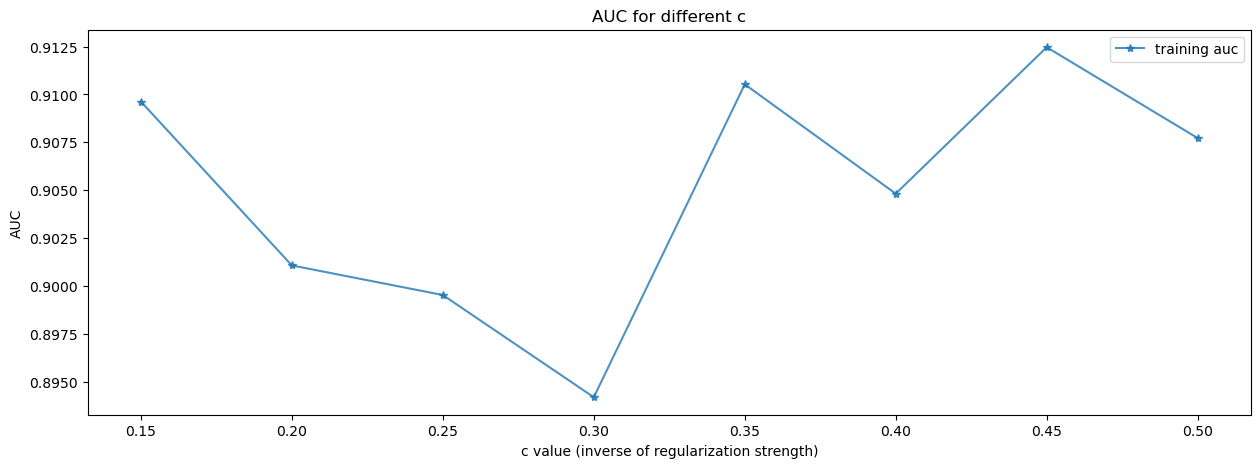

In [ ]:
#Hyperparameter optimization loop optimize c value
for cluster in [3]:
    print("\nCluster ",cluster,": ")
    xTrain = xSubTrain[xSubTrain['UserCluster'] == cluster]
    xTest = xSubTest[xSubTest['UserCluster'] == cluster]
    yTrain = ySubTrain.loc[xTrain.index]
    yTest = ySubTest.loc[xTest.index]
    
    #Logistic regression get optimal c (inverse of regularization strength)
    samples = [val / 100.0 for val in range(15,55,5)]
    cvList = []
    cvListAvg = []
    i = 0
    for s in samples:
        print(s)
        lrModel = LogisticRegression(C = s, solver = 'liblinear')
        cvList.append(cross_val_score(lrModel, X = xTrain, y = yTrain['TARGET'], cv = 10, scoring = 'roc_auc'))
        cvListAvg.append(cvList[i].mean())
        i += 1

    cvlistAvg = np.array(cvListAvg)
    fig, ax = plt.subplots(1, 1, figsize = (15,5))
    ax.plot(samples, cvListAvg, '-*', label = 'training auc', alpha=0.8)
    ax.set_title('AUC for different c')
    ax.set_xlabel('c value (inverse of regularization strength)')
    ax.set_ylabel('AUC')
    ax.legend()
    plt.show()


In [ ]:
#Cluster and optimal c value
clusterCValue = {}
clusterCValue[0] = 0.35
clusterCValue[1] = 0.35
clusterCValue[2] = 0.35
clusterCValue[3] = 0.35
clusterCValue[4] = 0.35
clusterCValue[5] = 0.35
clusterCValue[6] = 0.35
# clusterCValue[7] = 0.35
# clusterCValue[8] = 0.35
# clusterCValue[9] = 0.35


In [ ]:
#xSubTrain = xSubTrain.replace([np.inf, -np.inf], 1)
#xSubTest = xSubTest.replace([np.inf, -np.inf], 1)

Cluster  4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Cluster  6
Cluster  0
Cluster  1
Cluster  2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Cluster  5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Cluster  3


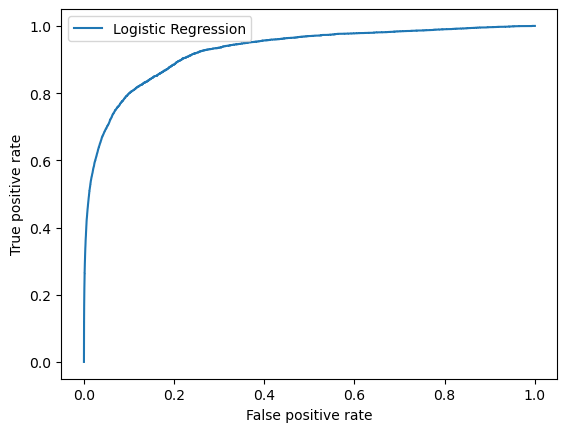

In [ ]:
#ROC curve loop <- add to section after all models are tested
#Modify this to have one big xTest and yTest and a single output graph
clusterModels = []
modelOutput = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
#for cluster in [7,4]:#keyList:
for cluster in keyList:
    print("Cluster ",cluster)
    cVal = clusterCValue[cluster]
    xTrain = xSubTrain[xSubTrain['UserCluster'] == cluster]
    xTest = xSubTest[xSubTest['UserCluster'] == cluster]
    yTrain = ySubTrain.loc[xTrain.index]
    yTest = ySubTest.loc[xTest.index]    
    lrModel = LogisticRegression(C=cVal, solver = 'liblinear').fit(xTrain, yTrain['TARGET'])
    lrProbs = lrModel.predict_proba(xTest)[:,1]
    modelOutputCluster = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
    modelOutputCluster['xAmt'] = xTest['Amount']
    modelOutputCluster['yTest'] = yTest['TARGET']
    modelOutputCluster['yProb'] = lrProbs
    modelOutput = pd.concat([modelOutput, modelOutputCluster])
    
fprLR, tprLR, thresholdsLR = roc_curve(modelOutput['yTest'], modelOutput['yProb'])
    
plt.plot(fprLR, tprLR, label="Logistic Regression")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()
#saving a copy 
lrModelOutput = modelOutput

In [ ]:
#Reload copy
modelOutput = lrModelOutput

Max Profit:  108738.15881823577 
Probability Threshold used:  0.06999999999999995


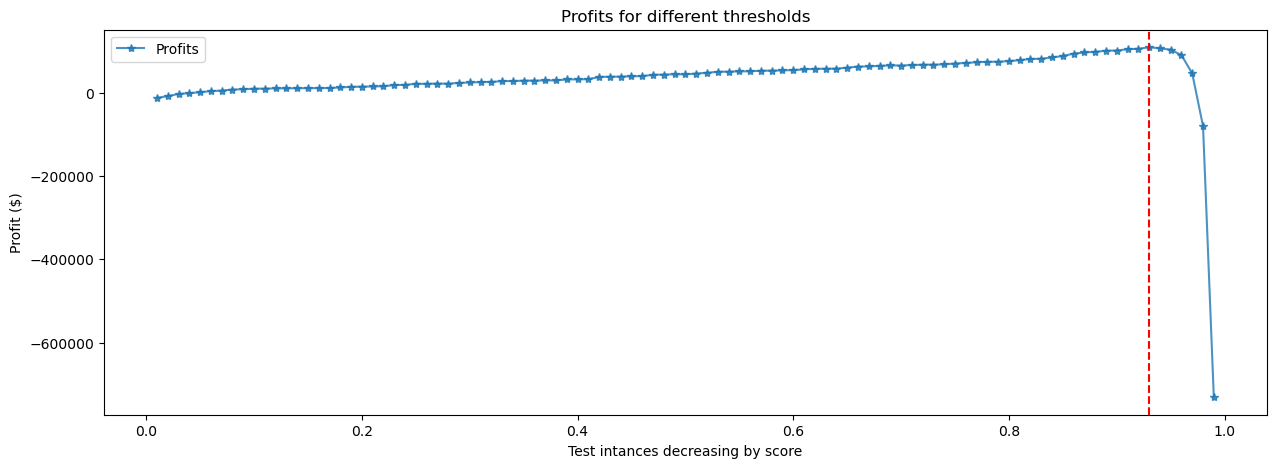

In [ ]:
#Profit curve loop analyzing profit per customer (expected profit)
#Assumption costs:
#analystFee = 30.0
#claimFee = 15.0
#claimPenalty = 1.04
analystFee = 15
claimFee = 0
claimPenalty = 0.04

#Benefit matrix:
#             p                                n
# Y   Amount - analystFee                 -AnalystFee
#  
# N  -claimFee - claimPenatly*Amount           0
#
valProbs = modelOutput
valProbs = valProbs.sort_values('yProb', ascending = False)
thresholds = {val/100.0: 0.0 for val in range(1,100)}
profitList = []
maxProfit = -float("Inf")
maxThreshold = -1

for threshold in thresholds.keys():
    valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= (1-threshold), 1, 0)
#    print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

    #Benefit matrix by grouping. 
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"
    
    profit = valProbs.groupby(['Category'])[['ProfitPerCustomer']].sum().reset_index()['ProfitPerCustomer'].sum()
    if profit > maxProfit:
        maxProfit = profit
        maxThreshold = threshold
    thresholds[threshold] = profit
    profitList.append(profit)

# maxProfit = max(profitList)
# maxThreshold = thresholds.get(maxProfit)


profitList = np.array(profitList)
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(thresholds.keys(), profitList, '-*', label = 'Profits', alpha=0.8)
plt.axvline(x=maxThreshold, color="r", linestyle="--")
ax.set_title('Profits for different thresholds')
ax.set_xlabel('Test intances decreasing by score')
ax.set_ylabel('Profit ($)')
ax.legend()

print("Max Profit: ",maxProfit,"\nProbability Threshold used: ",1-maxThreshold)

In [ ]:
#Expected Profit calculation of classifier:

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1-maxThreshold, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer: ',ExpectedProfit)

      p        n
Y  1203     4050
N  4335  4455705
Expected Profit per customer:  -0.005863927560358357


In [ ]:
#Expected Profit calculation of NAIVE model: 

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer by current NAIVE model: ',ExpectedProfit)

      p        n
Y     0        0
N  5538  4459755
Expected Profit per customer by current NAIVE model:  -2.694587711590316e-06


In [ ]:
###############################################################################################################################

In [ ]:
#################RANDOM FOREST############################################################################################


Cluster  3 : 
100
125
150
175
200
225
250
275


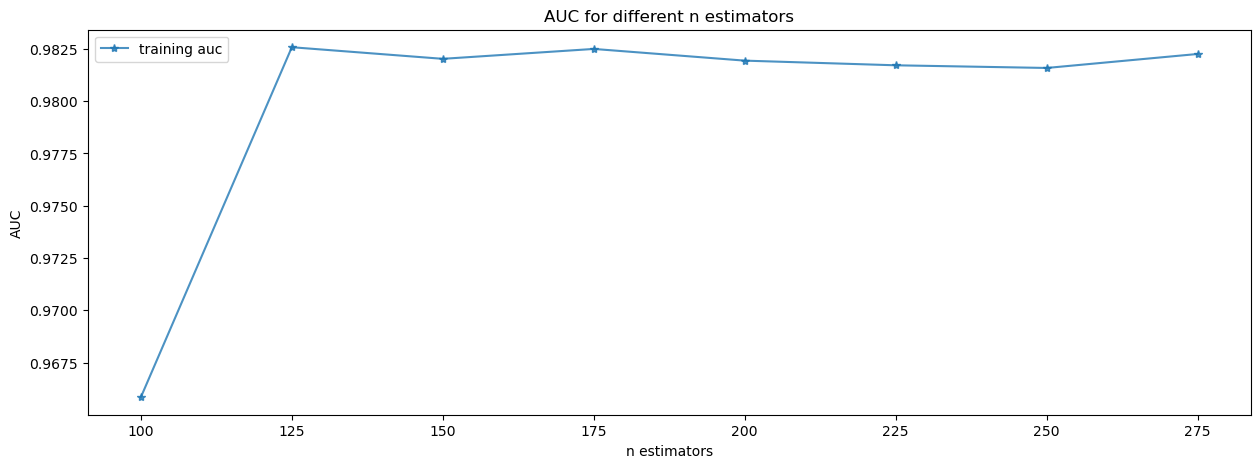

In [ ]:
#Hyperparameter optimization loop optimize numtrees value
for cluster in [3]:
    print("\nCluster ",cluster,": ")
    xTrain = xSubTrain[xSubTrain['UserCluster'] == cluster]
    xTest = xSubTest[xSubTest['UserCluster'] == cluster]
    yTrain = ySubTrain.loc[xTrain.index]
    yTest = ySubTest.loc[xTest.index]
    
    #Logistic regression get optimal c (inverse of regularization strength)
    samples = [val for val in range(100,300,25)]
    cvList = []
    cvListAvg = []
    i = 0
    for s in samples:
        print(s)
        rfModel = RandomForestClassifier(n_estimators=s)
        cvList.append(cross_val_score(rfModel, X = xTrain, y = yTrain['TARGET'], cv = 10, scoring = 'roc_auc'))
        cvListAvg.append(cvList[i].mean())
        i += 1

    cvlistAvg = np.array(cvListAvg)
    fig, ax = plt.subplots(1, 1, figsize = (15,5))
    ax.plot(samples, cvListAvg, '-*', label = 'training auc', alpha=0.8)
    ax.set_title('AUC for different n estimators')
    ax.set_xlabel('n estimators')
    ax.set_ylabel('AUC')
    ax.legend()
    plt.show()


In [ ]:
#Cluster and optimal c value
clusterCValue = {}
clusterCValue[0] = 125
clusterCValue[1] = 125
clusterCValue[2] = 125
clusterCValue[3] = 125
clusterCValue[4] = 125
clusterCValue[5] = 125
clusterCValue[6] = 125
# clusterCValue[7] = 125
# clusterCValue[8] = 125
# clusterCValue[9] = 125


In [ ]:
#xSubTrain = xSubTrain.replace([np.inf, -np.inf], 1)
#xSubTest = xSubTest.replace([np.inf, -np.inf], 1)

Cluster  4
Cluster  6
Cluster  0
Cluster  1
Cluster  2
Cluster  5
Cluster  3


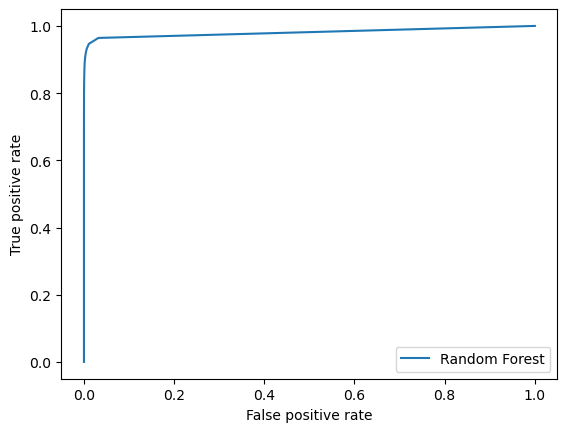

In [ ]:
#ROC curve loop <- add to section after all models are tested
#Modify this to have one big xTest and yTest and a single output graph
clusterModels = []
modelOutput = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
#for cluster in [7,4]:#keyList:
for cluster in keyList:
    print("Cluster ",cluster)
    cVal = clusterCValue[cluster]
    xTrain = xSubTrain[xSubTrain['UserCluster'] == cluster]
    xTest = xSubTest[xSubTest['UserCluster'] == cluster]
    yTrain = ySubTrain.loc[xTrain.index]
    yTest = ySubTest.loc[xTest.index]    
    rfModel = RandomForestClassifier(n_estimators=cVal).fit(xTrain, yTrain['TARGET'])
    rfProbs = rfModel.predict_proba(xTest)[:,1]
    modelOutputCluster = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
    modelOutputCluster['xAmt'] = xTest['Amount']
    modelOutputCluster['yTest'] = yTest['TARGET']
    modelOutputCluster['yProb'] = rfProbs
    modelOutput = pd.concat([modelOutput, modelOutputCluster])
    
fprRF, tprRF, thresholdsRF = roc_curve(modelOutput['yTest'], modelOutput['yProb'])
    
plt.plot(fprRF, tprRF, label="Random Forest")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()
#saving a copy 
rfModelOutput = modelOutput

In [ ]:
#Reload copy
modelOutput = rfModelOutput

Max Profit:  424885.7788581314 
Probability Threshold used:  0.13


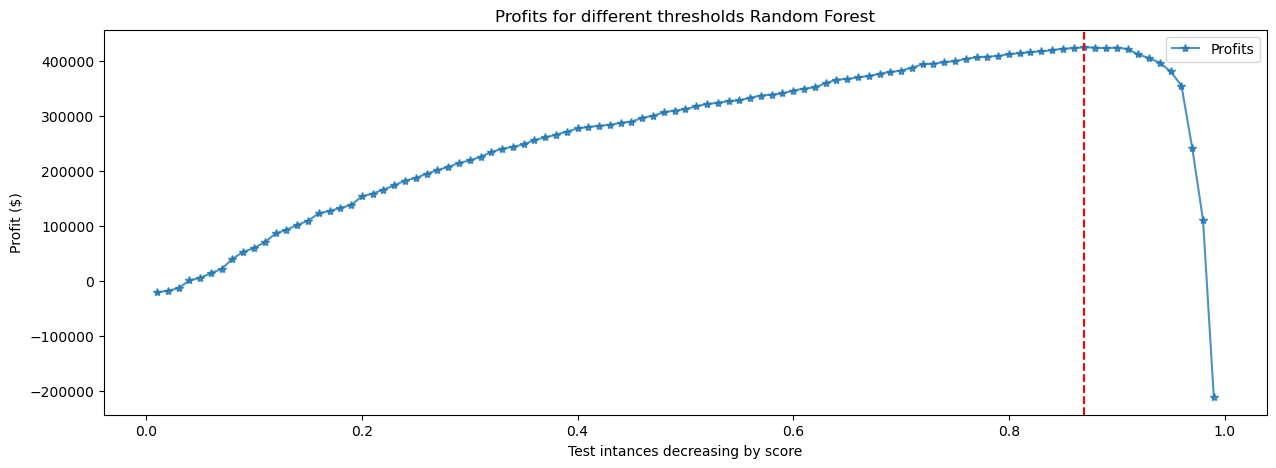

In [ ]:
#Profit curve loop analyzing profit per customer (expected profit)
#Assumption costs:
#analystFee = 30.0
#claimFee = 15.0
#claimPenalty = 1.04
analystFee = 15
claimFee = 0
claimPenalty = 0.04

#Benefit matrix:
#             p                                n
# Y   Amount - analystFee                 -AnalystFee
#  
# N  -claimFee - claimPenatly*Amount           0
#
valProbs = modelOutput
valProbs = valProbs.sort_values('yProb', ascending = False)
thresholds = {val/100.0: 0.0 for val in range(1,100)}
profitList = []
maxProfit = -float("Inf")
maxThreshold = -1

for threshold in thresholds.keys():
    valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= (1-threshold), 1, 0)
#    print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

    #Benefit matrix by grouping. 
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"
    
    profit = valProbs.groupby(['Category'])[['ProfitPerCustomer']].sum().reset_index()['ProfitPerCustomer'].sum()
    if profit > maxProfit:
        maxProfit = profit
        maxThreshold = threshold
    thresholds[threshold] = profit
    profitList.append(profit)

# maxProfit = max(profitList)
# maxThreshold = thresholds.get(maxProfit)


profitList = np.array(profitList)
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(thresholds.keys(), profitList, '-*', label = 'Profits', alpha=0.8)
plt.axvline(x=maxThreshold, color="r", linestyle="--")
ax.set_title('Profits for different thresholds Random Forest')
ax.set_xlabel('Test intances decreasing by score')
ax.set_ylabel('Profit ($)')
ax.legend()

print("Max Profit: ",maxProfit,"\nProbability Threshold used: ",1-maxThreshold)

In [ ]:
#Expected Profit calculation of classifier:

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1-maxThreshold, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer: ',ExpectedProfit)

      p        n
Y  4505     1370
N  1033  4458385
Expected Profit per customer:  0.024393816062996086


In [ ]:
#Expected Profit calculation of NAIVE model: 

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer by current NAIVE model: ',ExpectedProfit)

      p        n
Y    16        0
N  5522  4459755
Expected Profit per customer by current NAIVE model:  0.00010029736468428222


In [ ]:
###############################################################################################################################

In [ ]:
#################XG BOOST################################################################################################
#     clf = xgb.XGBClassifier(
#             n_estimators=5000,
#             max_depth=12,
#             learning_rate=0.02,
#             subsample=0.8,
#             colsample_bytree=0.4,
#             missing=-1,
#             eval_metric='auc',
#             tree_method='gpu_hist' 
#         )


Cluster  4 : 
50
100
150
200
250
300
350
400
450


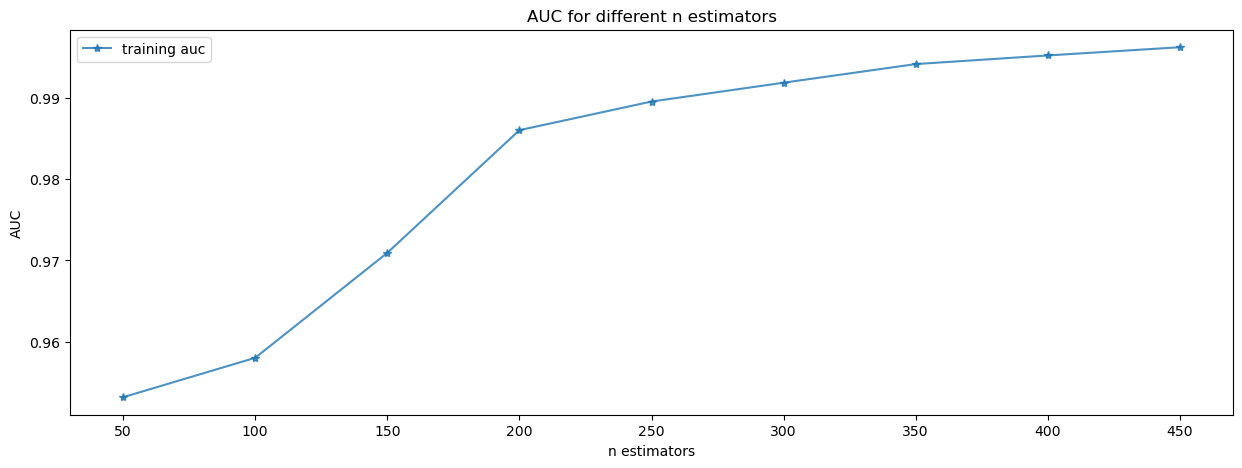


Cluster  6 : 
50
100
150
200
250
300
350
400
450


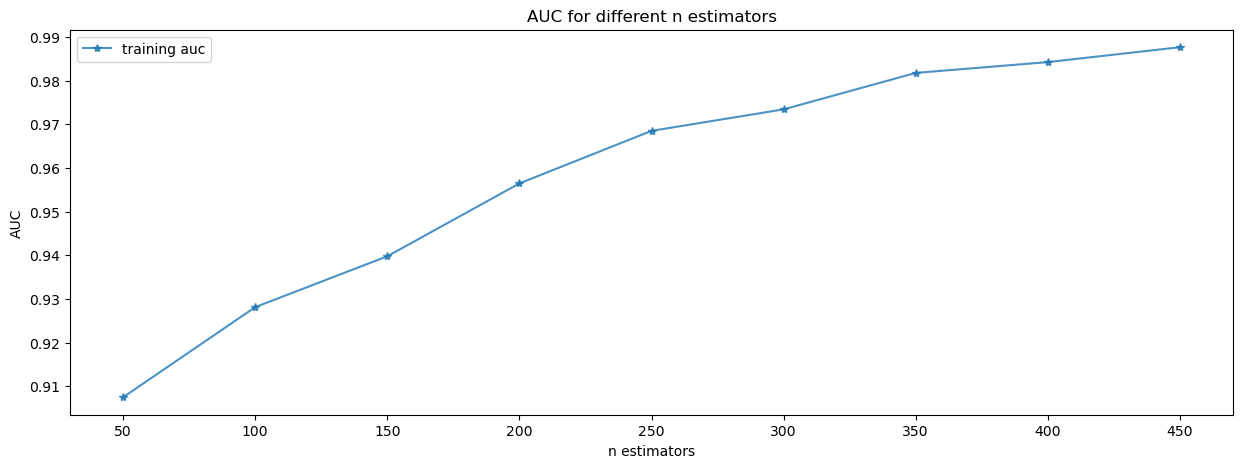


Cluster  0 : 
50
100
150
200
250
300
350
400
450


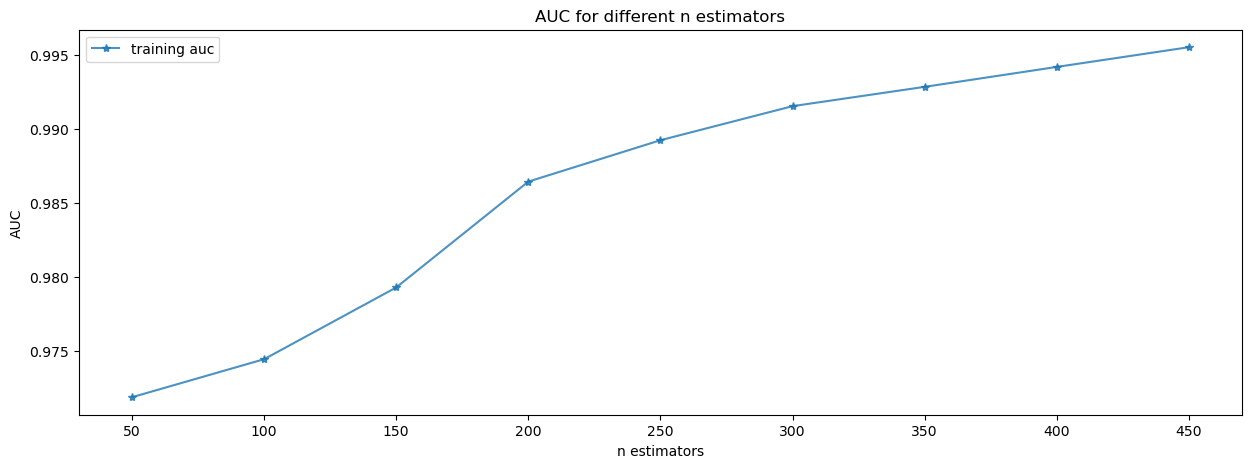


Cluster  1 : 
50
100
150
200
250
300
350
400
450


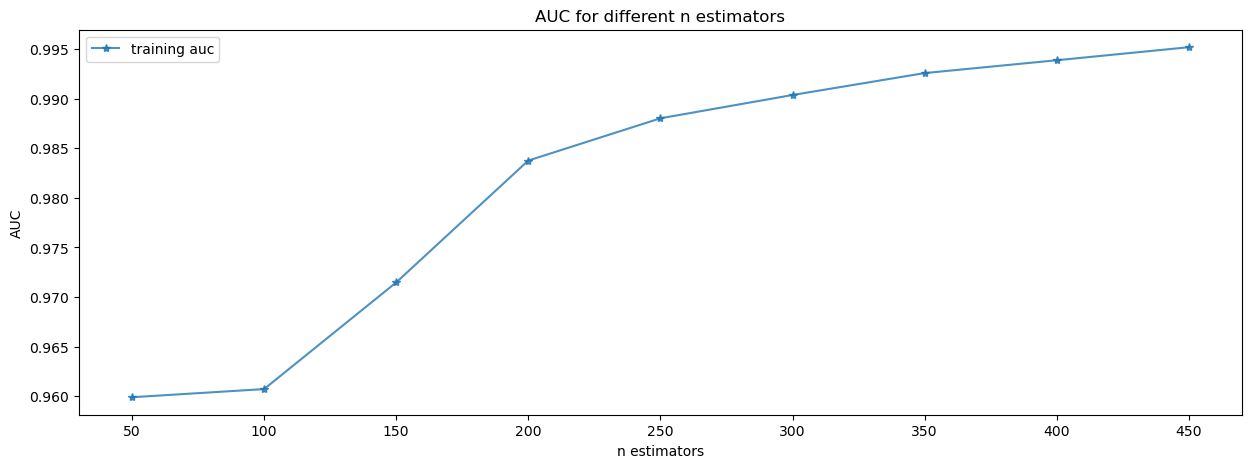


Cluster  2 : 
50
100
150
200
250
300
350
400
450


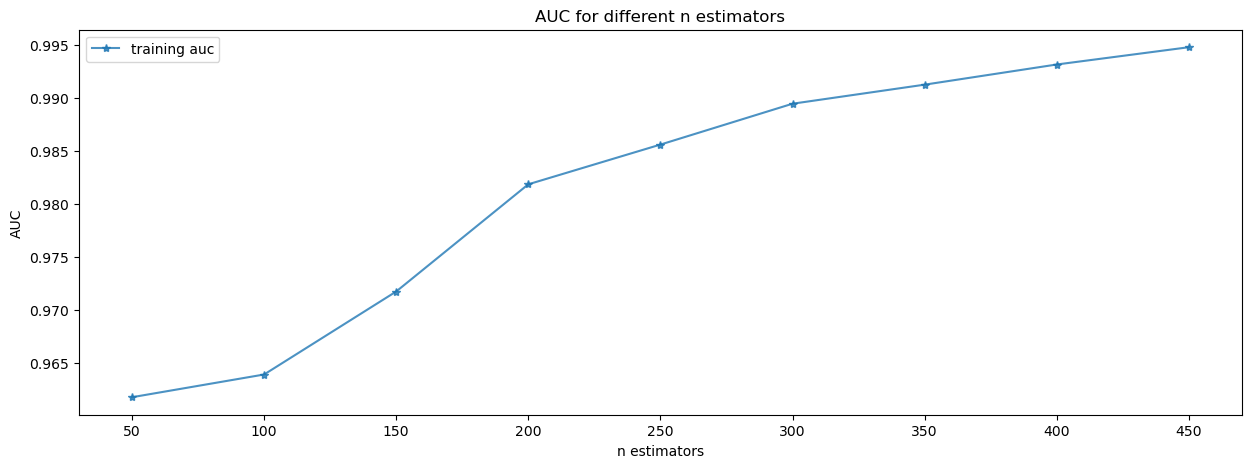


Cluster  5 : 
50
100
150
200
250
300
350
400
450


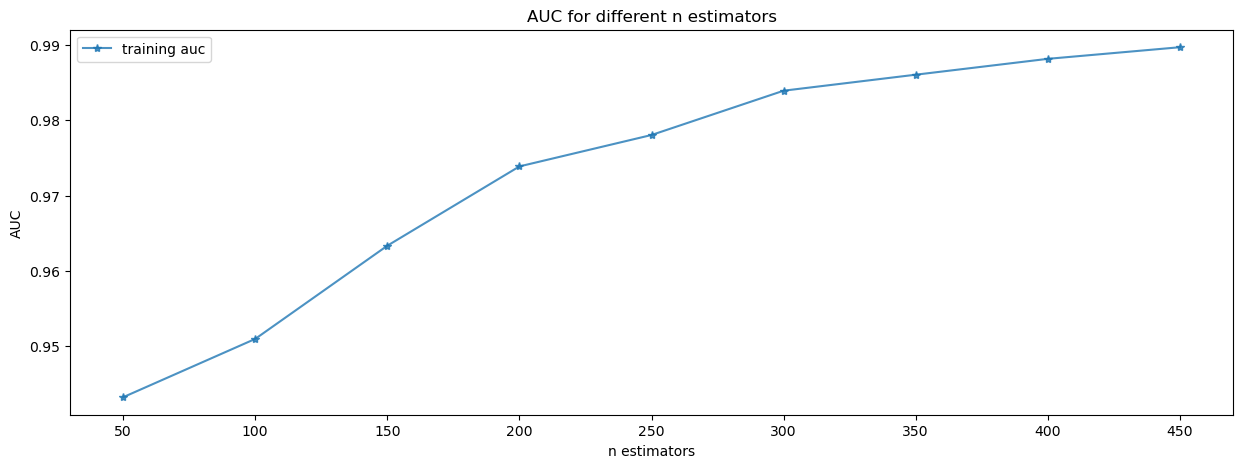


Cluster  3 : 
50
100
150
200
250
300
350
400
450


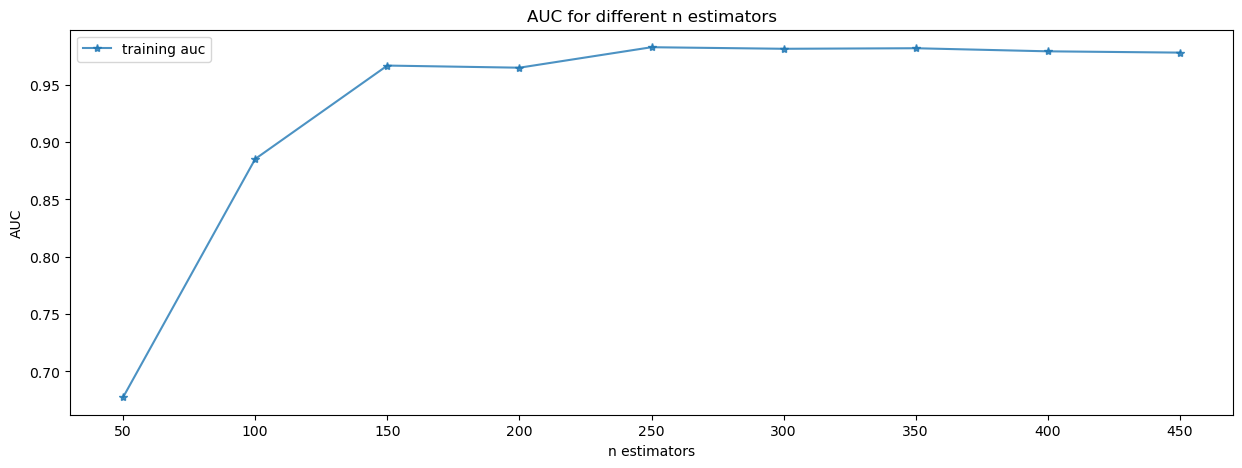

In [ ]:
#Hyperparameter optimization loop optimize c value
for cluster in keyList:
    print("\nCluster ",cluster,": ")
    xTrain = xSubTrain[xSubTrain['UserCluster'] == cluster]
    xTest = xSubTest[xSubTest['UserCluster'] == cluster]
    yTrain = ySubTrain.loc[xTrain.index]
    yTest = ySubTest.loc[xTest.index]
    
    #Logistic regression get optimal c (inverse of regularization strength)
    samples = [val * 50 for val in range(1,10,1)]
    cvList = []
    cvListAvg = []
    i = 0
    for s in samples:
        print(s)
        xgModel = xgb.XGBClassifier(n_estimators=s, max_depth=12, learning_rate=0.02, subsample=0.8, colsample_bytree=0.4,
                                missing=-1, eval_metric='auc', tree_method='gpu_hist')
        cvList.append(cross_val_score(xgModel, X = xTrain, y = yTrain['TARGET'], cv = 5, scoring = 'roc_auc'))
        cvListAvg.append(cvList[i].mean())
        i += 1

    cvlistAvg = np.array(cvListAvg)
    fig, ax = plt.subplots(1, 1, figsize = (15,5))
    ax.plot(samples, cvListAvg, '-*', label = 'training auc', alpha=0.8)
    ax.set_title('AUC for different n estimators')
    ax.set_xlabel('n estimators')
    ax.set_ylabel('AUC')
    ax.legend()
    plt.show()


In [ ]:
#Cluster and optimal c value
clusterCValue = {}
clusterCValue[0] = 300
clusterCValue[1] = 250
clusterCValue[2] = 300
clusterCValue[3] = 150
clusterCValue[4] = 200
clusterCValue[5] = 300
clusterCValue[6] = 350
# clusterCValue[7] = 150
# clusterCValue[8] = 150
# clusterCValue[9] = 150


In [ ]:
#xSubTrain = xSubTrain.replace([np.inf, -np.inf], 1)
#xSubTest = xSubTest.replace([np.inf, -np.inf], 1)

Cluster  4
Cluster  6
Cluster  0
Cluster  1
Cluster  2
Cluster  5
Cluster  3


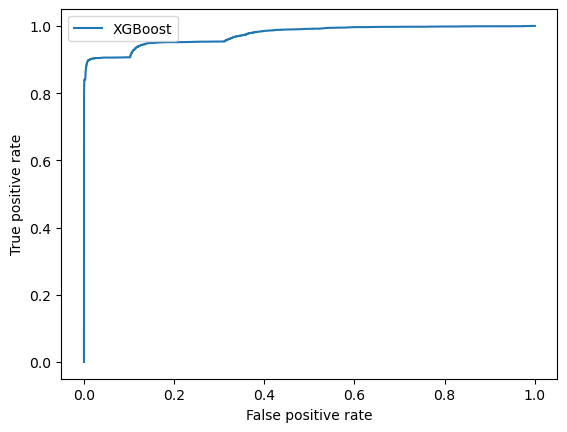

In [ ]:
#ROC curve loop <- add to section after all models are tested
#Modify this to have one big xTest and yTest and a single output graph
#xSubTrain = xSubTrain.replace([np.inf, -np.inf], 1)
#xSubTest = xSubTest.replace([np.inf, -np.inf], 1)
clusterModels = []
modelOutput = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
#for cluster in [7,4]:#keyList:
for cluster in keyList:
    print("Cluster ",cluster)
    cVal = clusterCValue[cluster]
    xTrain = xSubTrain[xSubTrain['UserCluster'] == cluster]
    xTest = xSubTest[xSubTest['UserCluster'] == cluster]
    yTrain = ySubTrain.loc[xTrain.index]
    yTest = ySubTest.loc[xTest.index]    
    xgModel = xgb.XGBClassifier(n_estimators=cVal, max_depth=12, learning_rate=0.02, subsample=0.8, colsample_bytree=0.4,
                                missing=-1, eval_metric='auc', tree_method='gpu_hist').fit(xTrain, yTrain['TARGET'])
    xgProbs = xgModel.predict_proba(xTest)[:,1]
    modelOutputCluster = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
    modelOutputCluster['xAmt'] = xTest['Amount']
    modelOutputCluster['yTest'] = yTest['TARGET']
    modelOutputCluster['yProb'] = xgProbs
    modelOutput = pd.concat([modelOutput, modelOutputCluster])
    
fprLR, tprLR, thresholdsLR = roc_curve(modelOutput['yTest'], modelOutput['yProb'])
    
plt.plot(fprLR, tprLR, label="XGBoost")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()
#saving a copy 
xgModelOutput = modelOutput

In [ ]:
#Reload copy
modelOutput = xgModelOutput

Max Profit:  434290.8980850885 
Probability Threshold used:  0.06000000000000005


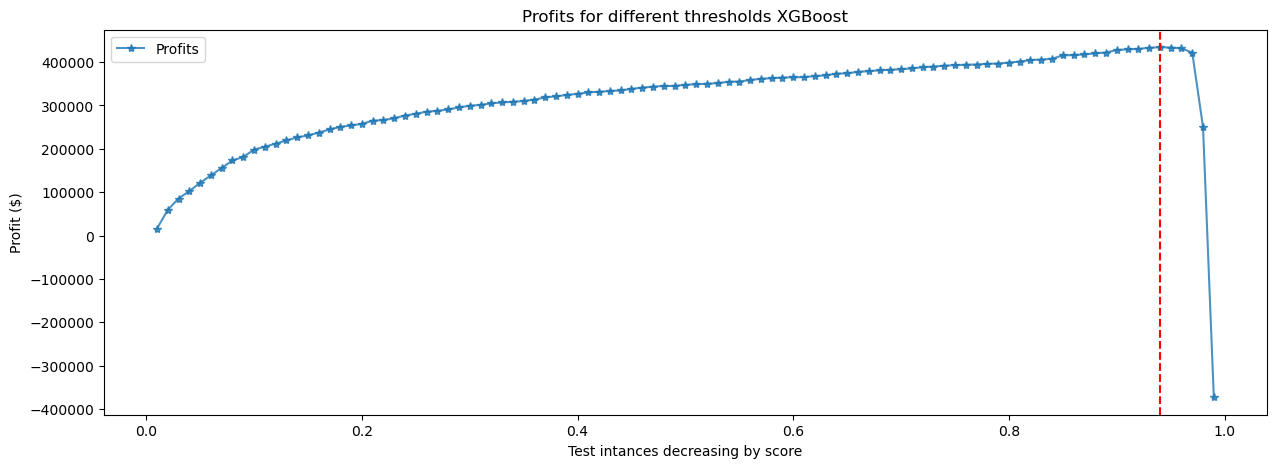

In [ ]:
#Profit curve loop analyzing profit per customer (expected profit)
#Assumption costs:
#analystFee = 30.0
#claimFee = 15.0
#claimPenalty = 1.04
analystFee = 15
claimFee = 0
claimPenalty = 0.04

#Benefit matrix:
#             p                                n
# Y   Amount - analystFee                 -AnalystFee
#  
# N  -claimFee - claimPenatly*Amount           0
#
valProbs = modelOutput
valProbs = valProbs.sort_values('yProb', ascending = False)
thresholds = {val/100.0: 0.0 for val in range(1,100)}
profitList = []
maxProfit = -float("Inf")
maxThreshold = -1

for threshold in thresholds.keys():
    valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= (1-threshold), 1, 0)
#    print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

    #Benefit matrix by grouping. 
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"
    
    profit = valProbs.groupby(['Category'])[['ProfitPerCustomer']].sum().reset_index()['ProfitPerCustomer'].sum()
    if profit > maxProfit:
        maxProfit = profit
        maxThreshold = threshold
    thresholds[threshold] = profit
    profitList.append(profit)

# maxProfit = max(profitList)
# maxThreshold = thresholds.get(maxProfit)


profitList = np.array(profitList)
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(thresholds.keys(), profitList, '-*', label = 'Profits', alpha=0.8)
plt.axvline(x=maxThreshold, color="r", linestyle="--")
ax.set_title('Profits for different thresholds XGBoost')
ax.set_xlabel('Test intances decreasing by score')
ax.set_ylabel('Profit ($)')
ax.legend()

print("Max Profit: ",maxProfit,"\nProbability Threshold used: ",1-maxThreshold)

In [ ]:
#Expected Profit calculation of classifier:

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1-maxThreshold, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer: ',ExpectedProfit)

      p        n
Y  4383      857
N  1155  4458898
Expected Profit per customer:  0.025331759879317056


In [ ]:
#Expected Profit calculation of NAIVE model: 

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer by current NAIVE model: ',ExpectedProfit)

      p        n
Y     0        0
N  5538  4459755
Expected Profit per customer by current NAIVE model:  -2.6945879465887727e-06


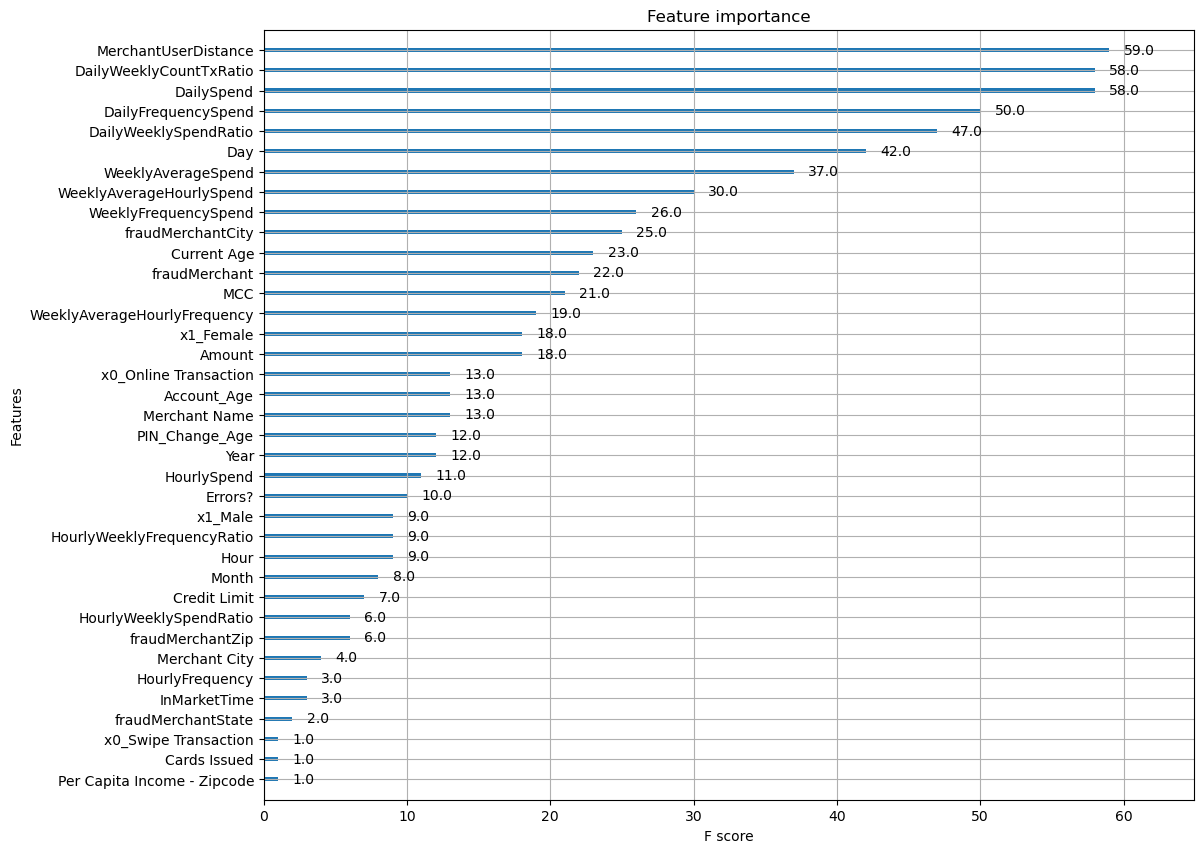

In [ ]:
plt.rcParams["figure.figsize"] = (12, 10)
plot_importance(xgModel)
pyplot.show()

In [ ]:
###############################################################################################################################

In [ ]:
#################Eval summary############################################################################################

In [ ]:
#XGB works best

In [ ]:
#Train all training data using xgb
#Cluster and optimal c value
clusterCValue = {}
clusterCValue[0] = 300
clusterCValue[1] = 250
clusterCValue[2] = 300
clusterCValue[3] = 150
clusterCValue[4] = 200
clusterCValue[5] = 300
clusterCValue[6] = 350
# clusterCValue[7] = 150
# clusterCValue[8] = 150
# clusterCValue[9] = 150


In [ ]:
XEval = pd.read_csv('XEval.csv')
yEval = pd.read_csv('yEval.csv')
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')

In [ ]:
X.shape

(22326462, 60)

In [ ]:
y.shape

(22326462, 4)

In [ ]:
X.isna().sum()

UserCluster                     0
Year                            0
Month                           0
Day                             0
Hour                            0
Amount                          0
Merchant Name                   0
Merchant City                   0
Merchant State                  0
MCC                             0
Errors?                         0
InMarketTime                    0
IsOnline                        0
fraudMerchant                   0
fraudMerchantState              0
fraudMerchantCity               0
fraudMerchantZip                0
topError                        0
Current Age                     0
MerchantUserDistance            0
Per Capita Income - Zipcode     0
Yearly Income - Person          0
Total Debt                      0
FICO Score                      0
Num Credit Cards                0
Cards Issued                    0
Credit Limit                    0
DailySpend                      0
WeeklyAverageSpend              0
DailyWeeklySpe

In [ ]:
y.isna().sum()

index             0
UserCardKey       0
UserClusterKey    0
TARGET            0
dtype: int64

In [ ]:
XEval.shape

(1723938, 60)

In [ ]:
yEval.shape

(1723938, 4)

In [ ]:
XEval.isna().sum()

UserCluster                     0
Year                            0
Month                           0
Day                             0
Hour                            0
Amount                          0
Merchant Name                   0
Merchant City                   0
Merchant State                  0
MCC                             0
Errors?                         0
InMarketTime                    0
IsOnline                        0
fraudMerchant                   0
fraudMerchantState              0
fraudMerchantCity               0
fraudMerchantZip                0
topError                        0
Current Age                     0
MerchantUserDistance            0
Per Capita Income - Zipcode     0
Yearly Income - Person          0
Total Debt                      0
FICO Score                      0
Num Credit Cards                0
Cards Issued                    0
Credit Limit                    0
DailySpend                      0
WeeklyAverageSpend              0
DailyWeeklySpe

In [ ]:
yEval.isna().sum()

index             0
UserCardKey       0
UserClusterKey    0
TARGET            0
dtype: int64

In [ ]:
X.replace([np.inf, -np.inf], 1, inplace=True)

In [ ]:
XEval = XEval.replace([np.inf, -np.inf], 1)

In [ ]:
XEval.UserCluster.unique()

array([4, 6, 0, 1, 2, 5, 3], dtype=int64)

In [ ]:
def reduceDatatypes(df):
    # Get the current data types of all columns
    dtypes = df.dtypes

    # Loop through all columns and check if the data type can be reduced
    for col in df.columns:
        col_dtype = dtypes[col]

        # Check if the data type is a float
        if col_dtype == 'float64':
            # Check if the column contains any NaN values
            if df[col].isna().sum() == 0:
                # Convert to float32
                df[col] = df[col].astype('float32')
            else:
                # Convert to nullable float32
                df[col] = df[col].astype(pd.StringDtype())

        # Check if the data type is an integer
        elif col_dtype == 'int64':
            # Check if the column contains any values outside the range of int8
            if ((df[col] >= -128) & (df[col] <= 127)).all():
                # Convert to int8
                df[col] = df[col].astype('int8')
            # Check if the column contains any values outside the range of int16
            elif ((df[col] >= -32768) & (df[col] <= 32767)).all():
                # Convert to int16
                df[col] = df[col].astype('int16')
            # Check if the column contains any values outside the range of int32
            elif ((df[col] >= -2147483648) & (df[col] <= 2147483647)).all():
                # Convert to int32
                df[col] = df[col].astype('int32')
            else:
                # Convert to int64
                df[col] = df[col].astype('int64')

        # Check if the data type is an object
        elif col_dtype == 'object':
            # Convert to category
            df[col] = df[col].astype('category')

    return df

X = reduceDatatypes(X)
XEval = reduceDatatypes(XEval)

In [ ]:
keyList = X['UserCluster'].unique()
keyList

array([4, 6, 0, 1, 2, 5, 3], dtype=int8)

Cluster  4
Cluster  6
Cluster  0
Cluster  1
Cluster  2
Cluster  5
Cluster  3


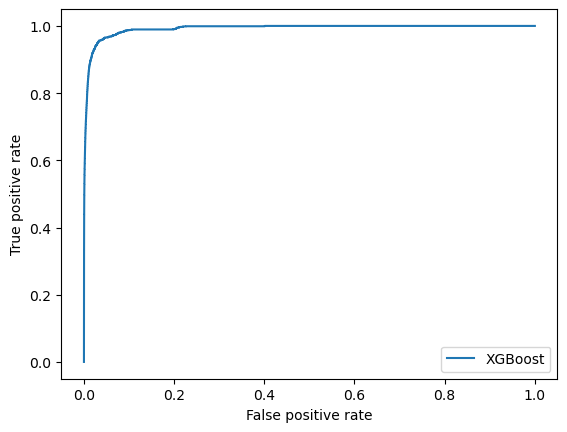

In [ ]:
#ROC curve loop <- add to section after all models are tested
#Modify this to have one big xTest and yTest and a single output graph

modelOutput = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
#for cluster in [7,4]:#keyList:
for cluster in keyList:
    print("Cluster ",cluster)
    cVal = clusterCValue[cluster]
    xTrain = X[X['UserCluster'] == cluster]
    xTest = XEval[XEval['UserCluster'] == cluster]
    yTrain = y.loc[xTrain.index]
    yTest = yEval.loc[xTest.index]    
    xgModel = xgb.XGBClassifier(n_estimators=cVal, max_depth=12, learning_rate=0.02, subsample=0.8, colsample_bytree=0.4,
                                missing=-1, eval_metric='auc', tree_method='gpu_hist').fit(xTrain, yTrain['TARGET'])
    xgProbs = xgModel.predict_proba(xTest)[:,1]
    modelOutputCluster = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
    modelOutputCluster['xAmt'] = xTest['Amount']
    modelOutputCluster['yTest'] = yTest['TARGET']
    modelOutputCluster['yProb'] = xgProbs
    modelOutput = pd.concat([modelOutput, modelOutputCluster])
    
fprLR, tprLR, thresholdsLR = roc_curve(modelOutput['yTest'], modelOutput['yProb'])
    
plt.plot(fprLR, tprLR, label="XGBoost")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()
#saving a copy 
fModelOutput = modelOutput

In [ ]:
#Reload copy
modelOutput = fModelOutput

In [ ]:
#Determine uplift and ROC on eval data

Max Profit:  75656.48485025391 
Probability Threshold used:  0.16000000000000003


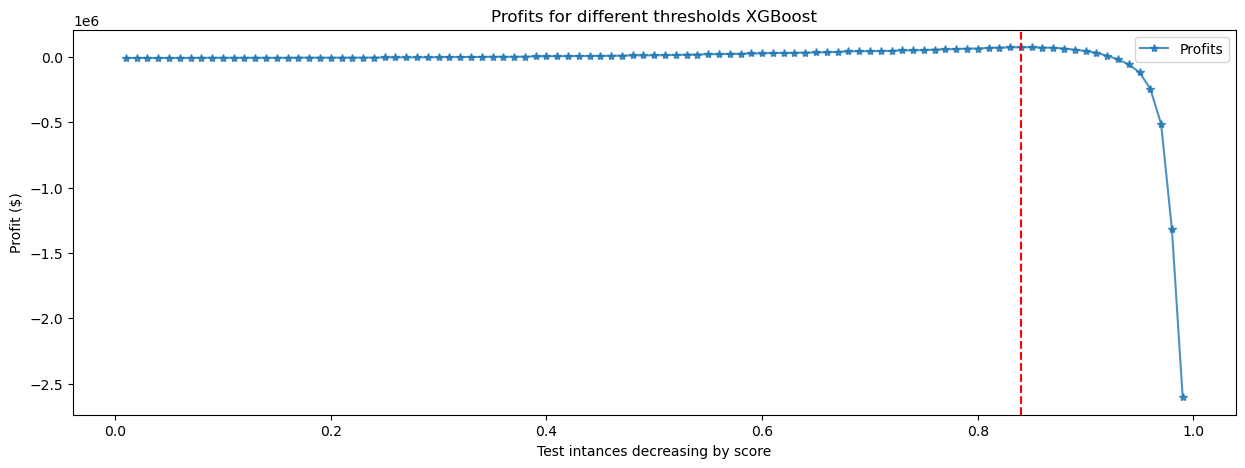

In [ ]:
#Profit curve loop analyzing profit per customer (expected profit)
#Assumption costs:
#analystFee = 30.0
#claimFee = 15.0
#claimPenalty = 1.04
analystFee = 15
claimFee = 0
claimPenalty = 0.04

#Benefit matrix:
#             p                                n
# Y   Amount - analystFee                 -AnalystFee
#  
# N  -claimFee - claimPenatly*Amount           0
#
valProbs = modelOutput
valProbs = valProbs.sort_values('yProb', ascending = False)
thresholds = {val/100.0: 0.0 for val in range(1,100)}
profitList = []
maxProfit = -float("Inf")
maxThreshold = -1

for threshold in thresholds.keys():
    valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= (1-threshold), 1, 0)
#    print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

    #Benefit matrix by grouping. 
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"
    
    profit = valProbs.groupby(['Category'])[['ProfitPerCustomer']].sum().reset_index()['ProfitPerCustomer'].sum()
    if profit > maxProfit:
        maxProfit = profit
        maxThreshold = threshold
    thresholds[threshold] = profit
    profitList.append(profit)

# maxProfit = max(profitList)
# maxThreshold = thresholds.get(maxProfit)


profitList = np.array(profitList)
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(thresholds.keys(), profitList, '-*', label = 'Profits', alpha=0.8)
plt.axvline(x=maxThreshold, color="r", linestyle="--")
ax.set_title('Profits for different thresholds XGBoost')
ax.set_xlabel('Test intances decreasing by score')
ax.set_ylabel('Profit ($)')
ax.legend()

print("Max Profit: ",maxProfit,"\nProbability Threshold used: ",1-maxThreshold)

In [ ]:
#Expected Profit calculation of classifier:

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1-maxThreshold, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer: ',ExpectedProfit)

      p        n
Y   979     1024
N  1108  1720827
Expected Profit per customer:  0.00684260036965992


In [ ]:
#Expected Profit calculation of NAIVE model: 

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer by current NAIVE model: ',ExpectedProfit)

      p        n
Y     0        0
N  2087  1721851
Expected Profit per customer by current NAIVE model:  -2.5086099776682676e-06


In [ ]:
#After performing some feature selection from the training example of XGB showns in the previous section:

In [ ]:
XEval.columns

Index(['UserCluster', 'Year', 'Month', 'Day', 'Hour', 'Amount',
       'Merchant Name', 'Merchant City', 'Merchant State', 'MCC', 'Errors?',
       'InMarketTime', 'IsOnline', 'fraudMerchant', 'fraudMerchantState',
       'fraudMerchantCity', 'fraudMerchantZip', 'topError', 'Current Age',
       'MerchantUserDistance', 'Per Capita Income - Zipcode',
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards', 'Cards Issued', 'Credit Limit', 'DailySpend',
       'WeeklyAverageSpend', 'DailyWeeklySpendRatio', 'HourlySpend',
       'WeeklyAverageHourlySpend', 'HourlyWeeklySpendRatio',
       'DailyFrequencySpend', 'WeeklyFrequencySpend',
       'DailyWeeklyCountTxRatio', 'HourlyFrequency',
       'WeeklyAverageHourlyFrequency', 'HourlyWeeklyFrequencyRatio',
       'PIN_Change_Age', 'Account_Age', 'x0_Chip Transaction',
       'x0_Online Transaction', 'x0_Swipe Transaction', 'x1_Female', 'x1_Male',
       'x2_Amex', 'x2_Discover', 'x2_Mastercard', 'x2_Visa', 'x3_

In [ ]:
XEval = XEval[['UserCluster', 'Year', 'Day', 'Amount',
       'Merchant Name', 'Merchant State', 'MCC', 
       'IsOnline', 'fraudMerchant', 
       'fraudMerchantCity', 'topError', 'Current Age',
       'MerchantUserDistance', 
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards', 'DailySpend',
       'WeeklyAverageSpend', 'DailyWeeklySpendRatio', 'HourlySpend',
       'WeeklyAverageHourlySpend', 
       'DailyFrequencySpend', 'WeeklyFrequencySpend',
       'DailyWeeklyCountTxRatio', 
       'WeeklyAverageHourlyFrequency', 
       'PIN_Change_Age', 'Account_Age', 'x0_Chip Transaction',
       'x0_Online Transaction', 'x1_Female', 
       'x2_Amex', 'x2_Discover', 'x2_Mastercard', 'x2_Visa', 'x3_Credit',
       'x3_Debit', 'x3_Debit (Prepaid)', 'x4_NO', 'x4_YES', 'x5_18-30',
       'x5_30-40', 'x5_40-50', 'x5_50-60', 'x5_60+']]

In [ ]:
X = X[['UserCluster', 'Year', 'Day', 'Amount',
       'Merchant Name', 'Merchant State', 'MCC', 
       'IsOnline', 'fraudMerchant', 
       'fraudMerchantCity', 'topError', 'Current Age',
       'MerchantUserDistance', 
       'Yearly Income - Person', 'Total Debt', 'FICO Score',
       'Num Credit Cards', 'DailySpend',
       'WeeklyAverageSpend', 'DailyWeeklySpendRatio', 'HourlySpend',
       'WeeklyAverageHourlySpend', 
       'DailyFrequencySpend', 'WeeklyFrequencySpend',
       'DailyWeeklyCountTxRatio', 
       'WeeklyAverageHourlyFrequency', 
       'PIN_Change_Age', 'Account_Age', 'x0_Chip Transaction',
       'x0_Online Transaction', 'x1_Female', 
       'x2_Amex', 'x2_Discover', 'x2_Mastercard', 'x2_Visa', 'x3_Credit',
       'x3_Debit', 'x3_Debit (Prepaid)', 'x4_NO', 'x4_YES', 'x5_18-30',
       'x5_30-40', 'x5_40-50', 'x5_50-60', 'x5_60+']]

In [ ]:
# X = X[['UserCluster', 'Year', 'Month', 'Day', 'Hour', 'Amount',
#        'Merchant Name', 'Merchant City', 'MCC', 
#        'InMarketTime', 'IsOnline', 'fraudMerchant', 
#        'fraudMerchantCity', 'fraudMerchantZip', 'topError', 'Current Age',
#        'MerchantUserDistance', 
#        'Yearly Income - Person', 'FICO Score',
#        'Credit Limit', 'DailySpend',
#        'WeeklyAverageSpend', 'DailyWeeklySpendRatio', 'HourlySpend',
#        'WeeklyAverageHourlySpend', 'HourlyWeeklySpendRatio',
#        'DailyFrequencySpend', 'WeeklyFrequencySpend',
#        'DailyWeeklyCountTxRatio', 
#        'WeeklyAverageHourlyFrequency', 'HourlyWeeklyFrequencyRatio',
#        'PIN_Change_Age', 'Account_Age', 
#        'x0_Online Transaction', 'x1_Female', 
#        'x2_Amex', 'x2_Discover', 'x2_Mastercard', 'x2_Visa',
#        'x3_Debit (Prepaid)', 'x4_NO', 'x4_YES', 'x5_18-30',
#        'x5_30-40', 'x5_40-50', 'x5_50-60', 'x5_60+']]

In [ ]:
#Train all training data using xgb
#Cluster and optimal c value
clusterCValue = {}
clusterCValue[0] = 300
clusterCValue[1] = 250
clusterCValue[2] = 300
clusterCValue[3] = 150
clusterCValue[4] = 200
clusterCValue[5] = 300
clusterCValue[6] = 350
# clusterCValue[7] = 150
# clusterCValue[8] = 150
# clusterCValue[9] = 150


In [ ]:
#XEval = pd.read_csv('XEval.csv')
#yEval = pd.read_csv('yEval.csv')


In [ ]:
X.shape

(22326462, 45)

In [ ]:
y.shape

(22326462, 4)

In [ ]:
X.isna().sum()

UserCluster                     0
Year                            0
Day                             0
Amount                          0
Merchant Name                   0
Merchant State                  0
MCC                             0
IsOnline                        0
fraudMerchant                   0
fraudMerchantCity               0
topError                        0
Current Age                     0
MerchantUserDistance            0
Yearly Income - Person          0
Total Debt                      0
FICO Score                      0
Num Credit Cards                0
DailySpend                      0
WeeklyAverageSpend              0
DailyWeeklySpendRatio           0
HourlySpend                     0
WeeklyAverageHourlySpend        0
DailyFrequencySpend             0
WeeklyFrequencySpend            0
DailyWeeklyCountTxRatio         0
WeeklyAverageHourlyFrequency    0
PIN_Change_Age                  0
Account_Age                     0
x0_Chip Transaction             0
x0_Online Tran

In [ ]:
y.isna().sum()

index             0
UserCardKey       0
UserClusterKey    0
TARGET            0
dtype: int64

In [ ]:
XEval.shape

(1723938, 45)

In [ ]:
yEval.shape

(1723938, 4)

In [ ]:
XEval.isna().sum()

UserCluster                     0
Year                            0
Day                             0
Amount                          0
Merchant Name                   0
Merchant State                  0
MCC                             0
IsOnline                        0
fraudMerchant                   0
fraudMerchantCity               0
topError                        0
Current Age                     0
MerchantUserDistance            0
Yearly Income - Person          0
Total Debt                      0
FICO Score                      0
Num Credit Cards                0
DailySpend                      0
WeeklyAverageSpend              0
DailyWeeklySpendRatio           0
HourlySpend                     0
WeeklyAverageHourlySpend        0
DailyFrequencySpend             0
WeeklyFrequencySpend            0
DailyWeeklyCountTxRatio         0
WeeklyAverageHourlyFrequency    0
PIN_Change_Age                  0
Account_Age                     0
x0_Chip Transaction             0
x0_Online Tran

In [ ]:
yEval.isna().sum()

index             0
UserCardKey       0
UserClusterKey    0
TARGET            0
dtype: int64

In [ ]:
X = X.replace([np.inf, -np.inf], 1)

In [ ]:
XEval = XEval.replace([np.inf, -np.inf], 1)

In [ ]:
XEval.UserCluster.unique()

array([4, 6, 0, 1, 2, 5, 3], dtype=int8)

Cluster  4
Cluster  6
Cluster  0
Cluster  1
Cluster  2
Cluster  5
Cluster  3


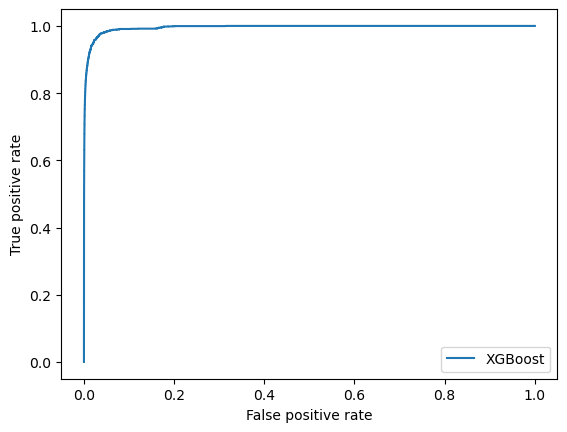

In [ ]:
#ROC curve loop <- add to section after all models are tested
#Modify this to have one big xTest and yTest and a single output graph

modelOutput = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
#for cluster in [7,4]:#keyList:
for cluster in keyList:
    print("Cluster ",cluster)
    cVal = clusterCValue[cluster]
    xTrain = X[X['UserCluster'] == cluster]
    xTest = XEval[XEval['UserCluster'] == cluster]
    yTrain = y.loc[xTrain.index]
    yTest = yEval.loc[xTest.index]    
    xgModel = xgb.XGBClassifier(n_estimators=cVal, max_depth=12, learning_rate=0.02, subsample=0.8, colsample_bytree=0.4,
                                missing=-1, eval_metric='auc', tree_method='gpu_hist').fit(xTrain, yTrain['TARGET'])
    xgProbs = xgModel.predict_proba(xTest)[:,1]
    modelOutputCluster = pd.DataFrame(columns = ['xAmt', 'yTest', 'yProb'])
    modelOutputCluster['xAmt'] = xTest['Amount']
    modelOutputCluster['yTest'] = yTest['TARGET']
    modelOutputCluster['yProb'] = xgProbs
    modelOutput = pd.concat([modelOutput, modelOutputCluster])
    
fprLR, tprLR, thresholdsLR = roc_curve(modelOutput['yTest'], modelOutput['yProb'])
    
plt.plot(fprLR, tprLR, label="XGBoost")
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()

In [ ]:
#Determine uplift and ROC on eval data

Max Profit:  94679.37215075157 
Probability Threshold used:  0.09999999999999998


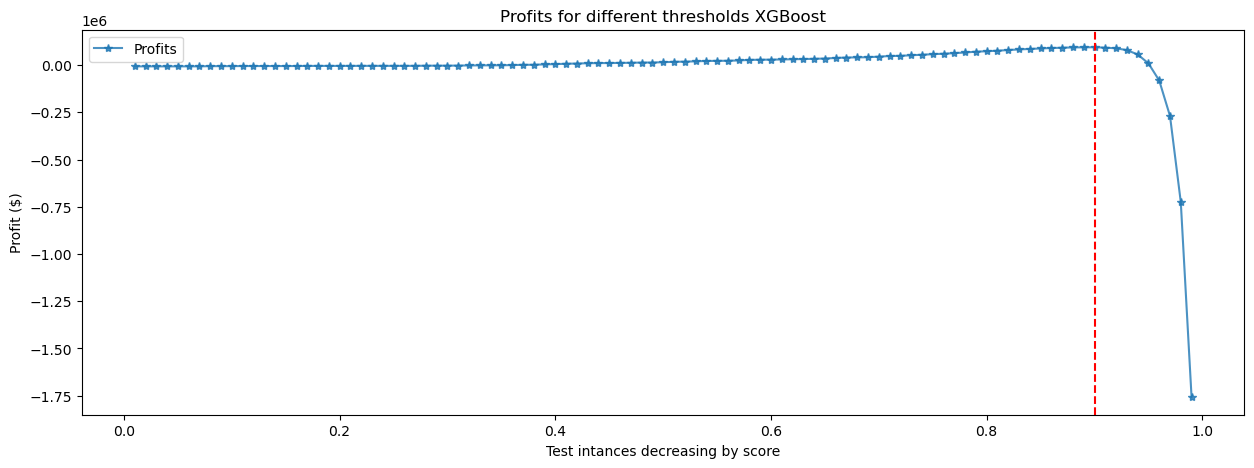

In [ ]:
#Profit curve loop analyzing profit per customer (expected profit)
#Assumption costs:
#analystFee = 30.0
#claimFee = 15.0
#claimPenalty = 1.04
analystFee = 15
claimFee = 0
claimPenalty = 0.04

#Benefit matrix:
#             p                                n
# Y   Amount - analystFee                 -AnalystFee
#  
# N  -claimFee - claimPenatly*Amount           0
#
valProbs = modelOutput
valProbs = valProbs.sort_values('yProb', ascending = False)
thresholds = {val/100.0: 0.0 for val in range(1,100)}
profitList = []
maxProfit = -float("Inf")
maxThreshold = -1

for threshold in thresholds.keys():
    valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= (1-threshold), 1, 0)
#    print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

    #Benefit matrix by grouping. 
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
    valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
    valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"
    
    profit = valProbs.groupby(['Category'])[['ProfitPerCustomer']].sum().reset_index()['ProfitPerCustomer'].sum()
    if profit > maxProfit:
        maxProfit = profit
        maxThreshold = threshold
    thresholds[threshold] = profit
    profitList.append(profit)

# maxProfit = max(profitList)
# maxThreshold = thresholds.get(maxProfit)


profitList = np.array(profitList)
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(thresholds.keys(), profitList, '-*', label = 'Profits', alpha=0.8)
plt.axvline(x=maxThreshold, color="r", linestyle="--")
ax.set_title('Profits for different thresholds XGBoost')
ax.set_xlabel('Test intances decreasing by score')
ax.set_ylabel('Profit ($)')
ax.legend()

print("Max Profit: ",maxProfit,"\nProbability Threshold used: ",1-maxThreshold)

In [ ]:
#Expected Profit calculation of classifier:

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1-maxThreshold, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer: ',ExpectedProfit)

      p        n
Y  1260     1098
N   827  1720753
Expected Profit per customer:  0.010720809098992663


In [ ]:
#Expected Profit calculation of NAIVE model: 

valProbs['PredictedChurnByProbability'] = np.where(valProbs['yProb'] >= 1, 1, 0)
print(pd.DataFrame(metrics.confusion_matrix(valProbs['yTest'], valProbs['PredictedChurnByProbability'], labels = [1, 0]).T, columns = ['p', 'n'], index = ['Y','N']))

valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = valProbs['xAmt'] - analystFee
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'ProfitPerCustomer'] = -analystFee
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = -claimFee - claimPenalty*valProbs['xAmt']
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'ProfitPerCustomer'] = 0.0

#Benefit matrix by grouping. 
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "TP"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 1), 'Category'] = "FP"
valProbs.loc[(valProbs['yTest'] == 1) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "FN"
valProbs.loc[(valProbs['yTest'] == 0) & (valProbs['PredictedChurnByProbability'] == 0), 'Category'] = "TN"

counts = valProbs.groupby(['Category'])[['ProfitPerCustomer']].count().reset_index()

avgAmount = valProbs['xAmt'].mean()

TPc = counts[counts['Category']=='TP']['ProfitPerCustomer'].sum()
TPv = avgAmount - analystFee
FPc = counts[counts['Category']=='FP']['ProfitPerCustomer'].sum()
FPv = -analystFee
TNc = counts[counts['Category']=='TN']['ProfitPerCustomer'].sum()
TNv = 0
FNc = counts[counts['Category']=='FN']['ProfitPerCustomer'].sum()
FNv = -claimFee - avgAmount*claimPenalty
pp = (TPc + FNc) / (TPc + TNc + FPc + FNc)
nn = (FPc + TNc) / (TPc + TNc + FPc + FNc)
TPR = TPc / (TPc + FNc)
FPR = FPc / (FPc + TNc)
TNR = TNc / (TPc + FNc)
FNR = FNc / (FPc + TNc)
ExpectedProfit = (pp*((TPR*TPv)+(FNR*FNv))) + (nn*((FPR*FPv)+(TNR*TNv)))
print('Expected Profit per customer by current NAIVE model: ',ExpectedProfit)

      p        n
Y     0        0
N  2087  1721851
Expected Profit per customer by current NAIVE model:  -2.5086084103911334e-06


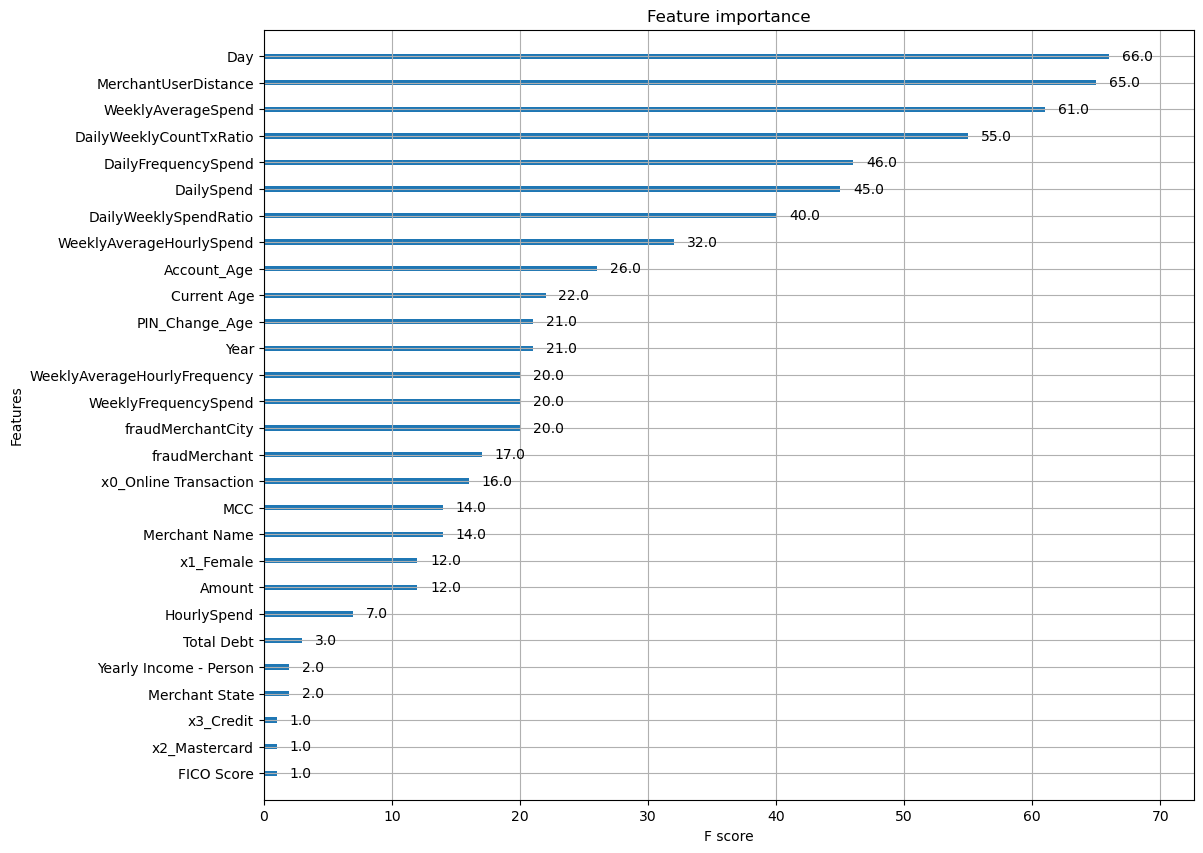

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (12, 10)
plot_importance(xgModel)
pyplot.show()

In [ ]:
#Done